In [1]:
#hide
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org  -Uqq fastbook
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org  kaggle
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org  dtreeviz
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org  -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn

import fastbook
fastbook.setup_book()

Looking in links: https://sklearn-nightly.scdn8.secure.raxcdn.com


In [2]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Tabular Modeling Deep Dive

Tabular modeling takes data in the form of a table (like a spreadsheet or CSV). The objective is to predict the value in one column based on the values in the other columns. In this chapter we will not only look at deep learning but also more general machine learning techniques like random forests, as they can give better results depending on your problem.

테이블 형식 모델링은 데이터를 테이블 형식 (예 : 스프레드 시트 또는 CSV)으로 가져옵니다. 목표는 다른 열의 값을 기반으로 한 열의 값을 예측하는 것입니다. 이 장에서는 문제에 따라 더 나은 결과를 제공 할 수 있으므로 딥 러닝뿐만 아니라 랜덤 포레스트와 같은보다 일반적인 머신 러닝 기술도 살펴볼 것입니다.

We will look at how we should preprocess and clean the data as well as how to interpret the result of our models after training, but first, we will see how we can feed columns that contain categories into a model that expects numbers by using embeddings.

학습 후 모델의 결과를 해석하는 방법뿐만 아니라 데이터를 사전 처리하고 정리하는 방법을 살펴 보 겠지만 먼저 임베딩을 사용하여 숫자를 예상하는 모델에 범주가 포함 된 열을 공급할 수있는 방법을 살펴 보겠습니다.

## Categorical Embeddings

In tabular data some columns may contain numerical data, like "age," while others contain string values, like "sex." The numerical data can be directly fed to the model (with some optional preprocessing), but the other columns need to be converted to numbers. Since the values in those correspond to different categories, we often call this type of variables *categorical variables*. The first type are called *continuous variables*.

표 형식 데이터에서 일부 열에는 '연령'과 같은 숫자 데이터가 포함될 수 있고 다른 열에는 '성별'과 같은 문자열 값이 포함될 수 있습니다. 숫자 데이터는 모델에 직접 제공 될 수 있지만 (일부 선택적 사전 처리 포함) 다른 열은 숫자로 변환되어야합니다. 이들의 값은 서로 다른 범주에 해당하므로 이러한 유형의 변수를 * 범주 적 변수 *라고합니다. 첫 번째 유형은 * 연속 변수 *라고합니다.

> jargon: Continuous and Categorical Variables: Continuous variables are numerical data, such as "age," that can be directly fed to the model, since you can add and multiply them directly. Categorical variables contain a number of discrete levels, such as "movie ID," for which addition and multiplication don't have meaning (even if they're stored as numbers).

> 전문 용어 : 연속 형 및 범주 형 변수 : 연속 형 변수는 직접 더하고 곱할 수 있으므로 모델에 직접 공급할 수있는 "연령"과 같은 숫자 데이터입니다. 범주 형 변수에는 "영화 ID"와 같이 덧셈과 곱셈에 의미가없는 여러 개별 수준이 포함됩니다 (숫자로 저장 되더라도).

At the end of 2015, the [Rossmann sales competition](https://www.kaggle.com/c/rossmann-store-sales) ran on Kaggle. Competitors were given a wide range of information about various stores in Germany, and were tasked with trying to predict sales on a number of days. The goal was to help the company to manage stock properly and be able to satisfy demand without holding unnecessary inventory. The official training set provided a lot of information about the stores. It was also permitted for competitors to use additional data, as long as that data was made public and available to all participants.

2015 년 말 Kaggle에서 [Rossmann 세일즈 대회] (https://www.kaggle.com/c/rossmann-store-sales)가 진행되었습니다. 경쟁자들은 독일의 다양한 매장에 대한 광범위한 정보를 제공 받았으며 며칠 동안의 매출을 예측하는 작업을 맡았습니다. 목표는 회사가 재고를 제대로 관리하고 불필요한 재고를 보유하지 않고도 수요를 충족시킬 수 있도록 돕는 것이 었습니다. 공식 교육 세트는 상점에 대한 많은 정보를 제공했습니다. 또한 해당 데이터가 공개되어 모든 참가자에게 제공되는 한 경쟁 업체가 추가 데이터를 사용할 수 있도록 허용되었습니다.

One of the gold medalists used deep learning, in one of the earliest known examples of a state-of-the-art deep learning tabular model. Their method involved far less feature engineering, based on domain knowledge, than those of the other gold medalists. The paper, ["Entity Embeddings of Categorical Variables"](https://arxiv.org/abs/1604.06737) describes their approach. In an online-only chapter on the [book's website](https://book.fast.ai/) we show how to replicate it from scratch and attain the same accuracy shown in the paper. In the abstract of the paper the authors (Cheng Guo and Felix Berkhahn) say:

금메달리스트 중 한 명은 최첨단 딥 러닝 테이블 형식 모델의 가장 초기에 알려진 사례 중 하나 인 딥 러닝을 사용했습니다. 그들의 방법은 다른 금메달리스트의 방법보다 도메인 지식을 기반으로 한 기능 엔지니어링이 훨씬 적었습니다. 논문, [ "범주 형 변수의 엔티티 임베딩"] (https://arxiv.org/abs/1604.06737)은 그들의 접근 방식을 설명합니다. [도서 웹 사이트] (https://book.fast.ai/)의 온라인 전용 장에서 처음부터 복제하고 종이에 표시된 것과 동일한 정확도를 얻는 방법을 보여줍니다. 논문의 초록에서 저자 (Cheng Guo와 Felix Berkhahn)는 다음과 같이 말합니다.

> : Entity embedding not only reduces memory usage and speeds up neural networks compared with one-hot encoding, but more importantly by mapping similar values close to each other in the embedding space it reveals the intrinsic properties of the categorical variables... [It] is especially useful for datasets with lots of high cardinality features, where other methods tend to overfit... As entity embedding defines a distance measure for categorical variables it can be used for visualizing categorical data and for data clustering.

> : 엔터티 임베딩은 원-핫 인코딩에 비해 메모리 사용량을 줄이고 신경망의 속도를 높일뿐만 아니라 임베딩 공간에서 유사한 값을 서로 가깝게 매핑하여 범주 형 변수의 고유 한 속성을 나타냅니다 ... [It ]는 다른 방법이 과적 합되는 경향이있는 카디널리티가 많은 데이터 세트에 특히 유용합니다. 엔티티 임베딩은 범주 형 변수에 대한 거리 측정을 정의하므로 범주 형 데이터 시각화 및 데이터 클러스터링에 사용할 수 있습니다.

We have already noticed all of these points when we built our collaborative filtering model. We can clearly see that these insights go far beyond just collaborative filtering, however.

협업 필터링 모델을 구축 할 때 이미 이러한 모든 사항을 알아 차 렸습니다. 그러나 이러한 통찰력이 단순한 협업 필터링을 훨씬 뛰어 넘는다는 것을 분명히 알 수 있습니다.

The paper also points out that (as we discussed in the last chapter) an embedding layer is exactly equivalent to placing an ordinary linear layer after every one-hot-encoded input layer. The authors used the diagram in <<entity_emb>> to show this equivalence. Note that "dense layer" is a term with the same meaning as "linear layer," and the one-hot encoding layers represent inputs.

이 논문은 (마지막 장에서 논의했듯이) 임베딩 레이어는 모든 원-핫 인코딩 된 입력 레이어 다음에 일반 선형 레이어를 배치하는 것과 정확히 동일하다고 지적합니다. 저자는 << entity_emb >>의 다이어그램을 사용하여이 동등성을 보여주었습니다. "밀집 계층"은 "선형 계층"과 동일한 의미를 갖는 용어이며 원-핫 인코딩 계층은 입력을 나타냅니다.

<img alt="Entity embeddings in a neural network" width="600" caption="Entity embeddings in a neural network (courtesy of Cheng Guo and Felix Berkhahn)" id="entity_emb" src="images/att_00018.png">

The insight is important because we already know how to train linear layers, so this shows that from the point of view of the architecture and our training algorithm the embedding layer is just another layer. We also saw this in practice in the last chapter, when we built a collaborative filtering neural network that looks exactly like this diagram.

우리는 이미 선형 계층을 훈련하는 방법을 알고 있기 때문에 통찰력이 중요하므로 이는 아키텍처 및 훈련 알고리즘의 관점에서 임베딩 계층이 또 다른 계층이라는 것을 보여줍니다. 우리는이 다이어그램과 똑같이 보이는 협업 필터링 신경망을 구축했을 때 지난 장에서 실제로 이것을 보았습니다.

Where we analyzed the embedding weights for movie reviews, the authors of the entity embeddings paper analyzed the embedding weights for their sales prediction model. What they found was quite amazing, and illustrates their second key insight. This is that the embedding transforms the categorical variables into inputs that are both continuous and meaningful.

영화 리뷰에 대한 임베딩 가중치를 분석 한 곳에서 엔티티 임베딩 페이퍼의 작성자는 판매 예측 모델에 대한 임베딩 가중치를 분석했습니다. 그들이 찾은 것은 매우 놀랍고 두 번째 핵심 통찰력을 보여줍니다. 이는 임베딩이 범주 형 변수를 연속적이고 의미있는 입력으로 변환한다는 것입니다.

The images in <<state_emb>> illustrate these ideas. They are based on the approaches used in the paper, along with some analysis we have added.

<< state_emb >>의 이미지는 이러한 아이디어를 보여줍니다. 그들은 우리가 추가 한 몇 가지 분석과 함께 논문에 사용 된 접근법을 기반으로합니다.

<img alt="State embeddings and map" width="800" caption="State embeddings and map (courtesy of Cheng Guo and Felix Berkhahn)" id="state_emb" src="images/att_00015.png">

On the left is a plot of the embedding matrix for the possible values of the `State` category. For a categorical variable we call the possible values of the variable its "levels" (or "categories" or "classes"), so here one level is "Berlin," another is "Hamburg," etc. On the right is a map of Germany. The actual physical locations of the German states were not part of the provided data, yet the model itself learned where they must be, based only on the behavior of store sales!

왼쪽에는 '상태'카테고리의 가능한 값에 대한 임베딩 행렬의 플롯이 있습니다. 범주 형 변수의 경우 변수의 가능한 값을 "수준"(또는 "범주"또는 "클래스")이라고하므로 여기서 한 수준은 "베를린"이고 다른 수준은 "함부르크"등입니다. 오른쪽에는지도가 있습니다. 독일 독일주의 실제 물리적 위치는 제공된 데이터의 일부가 아니지만 모델 자체는 매장 판매 행동만을 기반으로 어디에 있어야 하는지를 학습했습니다!

Do you remember how we talked about *distance* between embeddings? The authors of the paper plotted the distance between store embeddings against the actual geographic distance between the stores (see <<store_emb>>). They found that they matched very closely!

임베딩 간 * 거리 *에 대해 어떻게 이야기했는지 기억하십니까? 이 논문의 저자는 매장 간의 실제 지리적 거리에 대해 매장 임베딩 간의 거리를 플로팅했습니다 (<< store_emb >> 참조). 그들은 매우 밀접하게 일치한다는 것을 발견했습니다!

<img alt="Store distances" width="600" caption="Store distances (courtesy of Cheng Guo and Felix Berkhahn)" id="store_emb" src="images/att_00016.png">

We've even tried plotting the embeddings for days of the week and months of the year, and found that days and months that are near each other on the calendar ended up close as embeddings too, as shown in <<date_emb>>.

우리는 심지어 요일과 연중 월에 대한 임베딩을 플로팅하려고 시도했으며 << date_emb >>에 표시된 것처럼 달력에서 서로 가까운 날짜와 월도 임베딩으로 가까워지는 것을 발견했습니다.

<img alt="Date embeddings" width="900" caption="Date embeddings" id="date_emb" src="images/att_00017.png">

What stands out in these two examples is that we provide the model fundamentally categorical data about discrete entities (e.g., German states or days of the week), and then the model learns an embedding for these entities that defines a continuous notion of distance between them. Because the embedding distance was learned based on real patterns in the data, that distance tends to match up with our intuitions.

이 두 가지 예에서 눈에 띄는 것은 개별 엔티티 (예 : 독일 주 또는 요일)에 대한 모델을 기본적으로 범주 형 데이터로 제공 한 다음 모델이 이들 엔티티 간의 거리에 대한 지속적인 개념을 정의하는 임베딩을 학습한다는 것입니다. . 임베딩 거리는 데이터의 실제 패턴을 기반으로 학습 되었기 때문에 그 거리는 우리의 직관과 일치하는 경향이 있습니다.

In addition, it is valuable in its own right that embeddings are continuous, because models are better at understanding continuous variables. This is unsurprising considering models are built of many continuous parameter weights and continuous activation values, which are updated via gradient descent (a learning algorithm for finding the minimums of continuous functions).

또한 모델이 연속 변수를 더 잘 이해하기 때문에 임베딩이 연속적이라는 것은 그 자체로 가치가 있습니다. 기울기 하강 (연속 함수의 최소값을 찾는 학습 알고리즘)을 통해 업데이트되는 많은 연속 매개 변수 가중치와 연속 활성화 값으로 모델이 구축된다는 점을 고려하면 이는 놀라운 일이 아닙니다.

Another benefit is that we can combine our continuous embedding values with truly continuous input data in a straightforward manner: we just concatenate the variables, and feed the concatenation into our first dense layer. In other words, the raw categorical data is transformed by an embedding layer before it interacts with the raw continuous input data. This is how fastai and Guo and Berkhahn handle tabular models containing continuous and categorical variables.

또 다른 이점은 연속 임베딩 값과 진정한 연속 입력 데이터를 간단한 방식으로 결합 할 수 있다는 것입니다. 변수를 연결하고 연결을 첫 번째 조밀 한 레이어에 공급하기 만하면됩니다. 즉, 원시 범주 형 데이터는 원시 연속 입력 데이터와 상호 작용하기 전에 임베딩 레이어에 의해 변환됩니다. 이것이 fastai와 Guo와 Berkhahn이 연속 형 및 범주 형 변수를 포함하는 테이블 형식 모델을 처리하는 방법입니다.

An example using this concatenation approach is how Google does it recommendations on Google Play, as explained in the paper ["Wide & Deep Learning for Recommender Systems"](https://arxiv.org/abs/1606.07792). <<google_recsys>> illustrates.

이 연결 접근 방식을 사용하는 예는 [ "추천 시스템을위한 와이드 & 딥 러닝"] (https://arxiv.org/abs/1606.07792) 백서에 설명 된대로 Google이 Google Play에서 추천하는 방식입니다. << google_recsys >>가 설명합니다.

<img alt="The Google Play recommendation system" width="800" caption="The Google Play recommendation system" id="google_recsys" src="images/att_00019.png">

Interestingly, the Google team actually combined both approaches we saw in the previous chapter: the dot product (which they call *cross product*) and neural network approaches.

흥미롭게도 Google 팀은 실제로 이전 장에서 본 두 가지 접근 방식, 즉 내적 (* 교차 곱 *이라고 함)과 신경망 접근 방식을 결합했습니다.

Let's pause for a moment. So far, the solution to all of our modeling problems has been: *train a deep learning model*. And indeed, that is a pretty good rule of thumb for complex unstructured data like images, sounds, natural language text, and so forth. Deep learning also works very well for collaborative filtering. But it is not always the best starting point for analyzing tabular data.

잠시 멈 춥니 다. 지금까지 우리의 모든 모델링 문제에 대한 해결책은 * 딥 러닝 모델 훈련 *이었습니다. 실제로 이미지, 사운드, 자연어 텍스트 등과 같은 복잡한 구조화되지 않은 데이터의 경우 이는 매우 좋은 경험 법칙입니다. 딥 러닝은 협업 필터링에도 매우 효과적입니다. 그러나 표 형식 데이터를 분석하는 데 항상 가장 좋은 시작점은 아닙니다.

## Beyond Deep Learning

Most machine learning courses will throw dozens of different algorithms at you, with a brief technical description of the math behind them and maybe a toy example. You're left confused by the enormous range of techniques shown and have little practical understanding of how to apply them.

대부분의 기계 학습 과정은 수학에 대한 간단한 기술 설명과 장난감 예제와 함께 수십 가지 알고리즘을 제공합니다. 당신은 보여준 방대한 범위의 기술에 혼란스러워하고 그것들을 적용하는 방법에 대한 실질적인 이해가 거의 없습니다.

The good news is that modern machine learning can be distilled down to a couple of key techniques that are widely applicable. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

좋은 소식은 최신 기계 학습이 널리 적용되는 몇 가지 핵심 기술로 축소 될 수 있다는 것입니다. 최근 연구에 따르면 대부분의 데이터 세트는 단 두 가지 방법으로 가장 잘 모델링 할 수 있습니다.

1. Ensembles of decision trees (i.e., random forests and gradient boosting machines), mainly for structured data (such as you might find in a database table at most companies)
주로 구조화 된 데이터 (대부분의 회사에서 데이터베이스 테이블에서 찾을 수 있음)를위한 의사 결정 트리 (예 : 랜덤 포레스트 및 그래디언트 부스팅 머신)의 앙상블

1. Multilayered neural networks learned with SGD (i.e., shallow and/or deep learning), mainly for unstructured data (such as audio, images, and natural language)
주로 비정형 데이터 (예 : 오디오, 이미지 및 자연어)에 대해 SGD로 학습 된 다층 신경망 (예 : 얕은 및 / 또는 딥 러닝)

Although deep learning is nearly always clearly superior for unstructured data, these two approaches tend to give quite similar results for many kinds of structured data. But ensembles of decision trees tend to train faster, are often easier to interpret, do not require special GPU hardware for inference at scale, and often require less hyperparameter tuning. They have also been popular for quite a lot longer than deep learning, so there is a more mature ecosystem of tooling and documentation around them.

딥 러닝은 비정형 데이터에 대해 거의 항상 분명히 우수하지만이 두 가지 접근 방식은 많은 종류의 구조화 된 데이터에 대해 매우 유사한 결과를 제공하는 경향이 있습니다. 그러나 의사 결정 트리의 앙상블은 더 빠르게 훈련하는 경향이 있고, 해석하기가 더 쉬우 며, 대규모 추론을위한 특수 GPU 하드웨어가 필요하지 않으며, 종종 하이퍼 파라미터 튜닝이 덜 필요합니다. 그들은 또한 딥 러닝보다 훨씬 오랫동안 인기가 있었기 때문에 도구와 문서화의 더 성숙한 생태계가 있습니다.

Most importantly, the critical step of interpreting a model of tabular data is significantly easier for decision tree ensembles. There are tools and methods for answering the pertinent questions, like: Which columns in the dataset were the most important for your predictions? How are they related to the dependent variable? How do they interact with each other? And which particular features were most important for some particular observation?

가장 중요한 것은 테이블 형식 데이터 모델을 해석하는 중요한 단계가 의사 결정 트리 앙상블의 경우 훨씬 더 쉽다는 것입니다. 다음과 같이 관련 질문에 답할 수있는 도구와 방법이 있습니다. 데이터 세트의 어떤 열이 예측에 가장 중요 했나요? 종속 변수와 어떤 관련이 있습니까? 서로 어떻게 상호 작용합니까? 그리고 어떤 특정 관찰에 가장 중요한 특징은 무엇입니까?

Therefore, ensembles of decision trees are our first approach for analyzing a new tabular dataset.
따라서 의사 결정 트리의 앙상블은 새로운 테이블 형식 데이터 세트를 분석하기위한 첫 번째 접근 방식입니다.

The exception to this guideline is when the dataset meets one of these conditions:
이 가이드 라인의 예외는 데이터 세트가 다음 조건 중 하나를 충족하는 경우입니다.

- There are some high-cardinality categorical variables that are very important ("cardinality" refers to the number of discrete levels representing categories, so a high-cardinality categorical variable is something like a zip code, which can take on thousands of possible levels).
매우 중요한 몇 가지 높은 카디널리티 범주 형 변수가 있습니다 ( "카디널리티"는 범주를 나타내는 개별 수준의 수를 나타내므로 높은 카디널리티 범주 형 변수는 수천 개의 가능한 수준을 취할 수있는 우편 번호와 유사합니다).

- There are some columns that contain data that would be best understood with a neural network, such as plain text data.
일반 텍스트 데이터와 같이 신경망에서 가장 잘 이해할 수있는 데이터가 포함 된 열이 있습니다.

In practice, when we deal with datasets that meet these exceptional conditions, we always try both decision tree ensembles and deep learning to see which works best. It is likely that deep learning will be a useful approach in our example of collaborative filtering, as we have at least two high-cardinality categorical variables: the users and the movies. But in practice things tend to be less cut-and-dried, and there will often be a mixture of high- and low-cardinality categorical variables and continuous variables.

실제로 이러한 예외적 인 조건을 충족하는 데이터 세트를 다룰 때 우리는 항상 의사 결정 트리 앙상블과 딥 러닝을 모두 시도하여 어떤 것이 가장 효과적인지 확인합니다. 사용자와 영화라는 두 가지 이상의 높은 카디널리티 범주 변수가 있으므로 딥 러닝은 협업 필터링의 예에서 유용한 접근 방식이 될 것입니다. 그러나 실제로는 덜 잘리고 건조되는 경향이 있으며 종종 카디널리티가 높고 낮은 범주 변수와 연속 변수가 혼합되어 있습니다.

Either way, it's clear that we are going to need to add decision tree ensembles to our modeling toolbox!

어느 쪽이든, 모델링 도구 상자에 의사 결정 트리 앙상블을 추가해야한다는 것은 분명합니다!

Up to now we've used PyTorch and fastai for pretty much all of our heavy lifting. But these libraries are mainly designed for algorithms that do lots of matrix multiplication and derivatives (that is, stuff like deep learning!). Decision trees don't depend on these operations at all, so PyTorch isn't much use.

지금까지 우리는 거의 모든 무거운 작업에 PyTorch와 fastai를 사용했습니다. 그러나 이러한 라이브러리는 주로 많은 행렬 곱셈과 도함수 (즉, 딥 러닝과 같은 것!)를 수행하는 알고리즘을 위해 설계되었습니다. 의사 결정 트리는 이러한 작업에 전혀 의존하지 않으므로 PyTorch는 많이 사용되지 않습니다.

Instead, we will be largely relying on a library called scikit-learn (also known as `sklearn`). Scikit-learn is a popular library for creating machine learning models, using approaches that are not covered by deep learning. In addition, we'll need to do some tabular data processing and querying, so we'll want to use the Pandas library. Finally, we'll also need NumPy, since that's the main numeric programming library that both sklearn and Pandas rely on.

대신 우리는 주로 scikit-learn ( 'sklearn'이라고도 함)이라는 라이브러리에 의존합니다. Scikit-learn은 딥 러닝에서 다루지 않는 접근 방식을 사용하여 기계 학습 모델을 만드는 데 널리 사용되는 라이브러리입니다. 또한 테이블 형식의 데이터 처리 및 쿼리를 수행해야하므로 Pandas 라이브러리를 사용하고 싶습니다. 마지막으로 NumPy도 필요합니다. 이것이 sklearn과 Pandas 모두가 의존하는 주요 숫자 프로그래밍 라이브러리이기 때문입니다.

We don't have time to do a deep dive into all these libraries in this book, so we'll just be touching on some of the main parts of each. For a far more in depth discussion, we strongly suggest Wes McKinney's [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) (O'Reilly). Wes is the creator of Pandas, so you can be sure that the information is accurate!

이 책에있는 모든 라이브러리에 대해 자세히 살펴볼 시간이 없으므로 각 라이브러리의 주요 부분 중 일부만 다루겠습니다. 보다 심도있는 논의를 위해 Wes McKinney의 [Python for Data Analysis] (http://shop.oreilly.com/product/0636920023784.do) (O'Reilly)를 강력히 제안합니다. Wes는 Pandas의 제작자이므로 정보가 정확하다는 것을 확신 할 수 있습니다!

First, let's gather the data we will use.

먼저 우리가 사용할 데이터를 모 읍시다.

## The Dataset

The dataset we use in this chapter is from the Blue Book for Bulldozers Kaggle competition, which has the following description: "The goal of the contest is to predict the sale price of a particular piece of heavy equipment at auction based on its usage, equipment type, and configuration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

이 장에서 사용하는 데이터 세트는 Blue Book for Bulldozers Kaggle 대회에서 가져온 것입니다. 여기에는 다음과 같은 설명이 있습니다. "대회의 목표는 사용, 장비에 따라 경매에서 특정 중장비의 판매 가격을 예측하는 것입니다. 유형 및 구성. 데이터는 경매 결과 게시에서 제공되며 사용 및 장비 구성에 대한 정보를 포함합니다. "

This is a very common type of dataset and prediction problem, similar to what you may see in your project or workplace. The dataset is available for download on Kaggle, a website that hosts data science competitions.

이것은 프로젝트 나 직장에서 볼 수있는 것과 유사한 매우 일반적인 유형의 데이터 세트 및 예측 문제입니다. 이 데이터 세트는 데이터 과학 대회를 주최하는 웹 사이트 Kaggle에서 다운로드 할 수 있습니다.

### Kaggle Competitions

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills.  There is nothing like getting hands-on practice and receiving real-time feedback to help you improve your skills.

Kaggle은 야심 찬 데이터 과학자 또는 기계 학습 기술을 향상시키려는 모든 사람을위한 멋진 리소스입니다. 실습 연습을하고 기술 향상에 도움이되는 실시간 피드백을받는 것만 큼 좋은 것은 없습니다.

Kaggle provides:
Kaggle은 다음을 제공합니다.

- Interesting datasets
흥미로운 데이터 세트
- Feedback on how you're doing
어떻게하고 있는지에 대한 피드백

- A leaderboard to see what's good, what's possible, and what's state-of-the-art
무엇이 좋은지, 무엇이 가능한지, 무엇이 최신인지를 볼 수있는 리더 보드

- Blog posts by winning contestants sharing useful tips and techniques
우승 한 참가자가 유용한 팁과 기술을 공유하는 블로그 게시물

Until now all our datasets have been available to download through fastai's integrated dataset system. However, the dataset we will be using in this chapter is only available from Kaggle. Therefore, you will need to register on the site, then go to the [page for the competition](https://www.kaggle.com/c/bluebook-for-bulldozers). On that page click "Rules," then "I Understand and Accept." (Although the competition has finished, and you will not be entering it, you still have to agree to the rules to be allowed to download the data.)

지금까지 모든 데이터 세트는 fastai의 통합 데이터 세트 시스템을 통해 다운로드 할 수있었습니다. 그러나이 장에서 사용할 데이터 세트는 Kaggle에서만 사용할 수 있습니다. 따라서 사이트에 등록한 다음 [대회 페이지] (https://www.kaggle.com/c/bluebook-for-bulldozers)로 이동해야합니다. 해당 페이지에서 "규칙"을 클릭 한 다음 "이해하고 동의합니다"를 클릭합니다. (대회가 종료되어 참가하지 않더라도 데이터 다운로드를 허용하려면 규칙에 동의해야합니다.)

The easiest way to download Kaggle datasets is to use the Kaggle API. You can install this using `pip` by running this in a notebook cell:

Kaggle 데이터 세트를 다운로드하는 가장 쉬운 방법은 Kaggle API를 사용하는 것입니다. 노트북 셀에서 실행하여`pip`를 사용하여 설치할 수 있습니다.

    !pip install kaggle

You need an API key to use the Kaggle API; to get one, click on your profile picture on the Kaggle website, and choose My Account, then click Create New API Token. This will save a file called *kaggle.json* to your PC. You need to copy this key on your GPU server. To do so, open the file you downloaded, copy the contents, and paste them in the following cell in the notebook associated with this chapter (e.g., `creds = '{"username":"xxx","key":"xxx"}'`):

Kaggle API를 사용하려면 API 키가 필요합니다. 계정을 얻으려면 Kaggle 웹 사이트에서 프로필 사진을 클릭하고 내 계정을 선택한 다음 새 API 토큰 생성을 클릭합니다. 그러면 * kaggle.json *이라는 파일이 PC에 저장됩니다. 이 키를 GPU 서버에 복사해야합니다. 이렇게하려면 다운로드 한 파일을 열고 내용을 복사 한 다음이 장과 관련된 노트북의 다음 셀에 붙여 넣습니다 (예 :`creds = '{ "username": "xxx", "key": "xxx). "} '`) :

In [3]:
creds = ''

Then execute this cell (this only needs to be run once):

그런 다음이 셀을 실행합니다 (한 번만 실행하면 됨).

In [4]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write(creds)
    cred_path.chmod(0o600)

Now you can download datasets from Kaggle! Pick a path to download the dataset to:

이제 Kaggle에서 데이터 세트를 다운로드 할 수 있습니다! 데이터 세트를 다운로드 할 경로를 선택하세요.

In [5]:
path = URLs.path('bluebook')
path

Path('/root/.fastai/archive/bluebook')

In [6]:
#hide
Path.BASE_PATH = path

And use the Kaggle API to download the dataset to that path, and extract it:

그리고 Kaggle API를 사용하여 해당 경로에 데이터 세트를 다운로드하고 추출합니다.

In [7]:
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

(#7) [Path('Valid.csv'),Path('median_benchmark.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('random_forest_benchmark_test.csv'),Path('Test.csv'),Path('TrainAndValid.csv')]

Now that we have downloaded our dataset, let's take a look at it!

이제 데이터 세트를 다운로드 했으므로 살펴 보겠습니다!

### Look at the Data(데이터 살펴보기)

Kaggle provides information about some of the fields of our dataset. The [Data](https://www.kaggle.com/c/bluebook-for-bulldozers/data) explains that the key fields in *train.csv* are:

Kaggle은 데이터 세트의 일부 필드에 대한 정보를 제공합니다. [데이터] ( https://www.kaggle.com/c/bluebook-for-bulldozers/data )는 * train.csv *의 주요 필드가 다음과 같다고 설명합니다.

- `SalesID`:: The unique identifier of the sale.
판매의 고유 식별자입니다.

- `MachineID`:: The unique identifier of a machine.  A machine can be sold multiple times.
기계의 고유 식별자입니다. 기계는 여러 번 판매 될 수 있습니다.

- `saleprice`:: What the machine sold for at auction (only provided in *train.csv*).
경매에서 기계가 판매 한 것 (* train.csv *에서만 제공됨).

- `saledate`:: The date of the sale.
판매 날짜입니다.

In any sort of data science work, it's important to *look at your data directly* to make sure you understand the format, how it's stored, what types of values it holds, etc. Even if you've read a description of the data, the actual data may not be what you expect. We'll start by reading the training set into a Pandas DataFrame. Generally it's a good idea to specify `low_memory=False` unless Pandas actually runs out of memory and returns an error. The `low_memory` parameter, which is `True` by default, tells Pandas to only look at a few rows of data at a time to figure out what type of data is in each column. This means that Pandas can actually end up using different data type for different rows, which generally leads to data processing errors or model training problems later.

모든 종류의 데이터 과학 작업에서 형식, 저장 방법, 보유하는 값 유형 등을 이해하기 위해 * 데이터를 직접 확인 *하는 것이 중요합니다. 데이터에 대한 설명을 읽은 경우에도 마찬가지입니다. , 실제 데이터가 예상 한 것과 다를 수 있습니다. 학습 세트를 Pandas DataFrame으로 읽는 것으로 시작합니다. 일반적으로 Pandas가 실제로 메모리가 부족하여 오류를 반환하지 않는 한`low_memory = False`를 지정하는 것이 좋습니다. 기본적으로 'True'인 'low_memory'매개 변수는 Pandas에게 한 번에 몇 행의 데이터 만 확인하여 각 열에 어떤 유형의 데이터가 있는지 파악하도록 지시합니다. 이는 Pandas가 실제로 다른 행에 대해 다른 데이터 유형을 사용하게 될 수 있음을 의미하며, 이는 일반적으로 나중에 데이터 처리 오류 또는 모델 학습 문제로 이어집니다.

Let's load our data and have a look at the columns:
데이터를로드하고 열을 살펴 보겠습니다.

In [8]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [9]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

That's a lot of columns for us to look at! Try looking through the dataset to get a sense of what kind of information is in each one. We'll shortly see how to "zero in" on the most interesting bits.

그것은 우리가 볼 수있는 많은 열입니다! 데이터 세트를 살펴보고 각각에 어떤 종류의 정보가 있는지 파악하십시오. 우리는 가장 흥미로운 부분을 "제로인"하는 방법을 곧 살펴볼 것입니다.

At this point, a good next step is to handle *ordinal columns*. This refers to columns containing strings or similar, but where those strings have a natural ordering. For instance, here are the levels of `ProductSize`:

이 시점에서 좋은 다음 단계는 * 순서 열 *을 처리하는 것입니다. 이것은 문자열 또는 이와 유사한 것을 포함하지만 해당 문자열이 자연스러운 순서를 갖는 열을 나타냅니다. 예를 들어 다음은`ProductSize` 수준입니다.

In [10]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

We can tell Pandas about a suitable ordering of these levels like so:

Pandas에게 다음과 같이 이러한 수준의 적절한 순서를 알릴 수 있습니다.

In [11]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [12]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

The most important data column is the dependent variable—that is, the one we want to predict. Recall that a model's metric is a function that reflects how good the predictions are. It's important to note what metric is being used for a project. Generally, selecting the metric is an important part of the project setup. In many cases, choosing a good metric will require more than just selecting a variable that already exists. It is more like a design process. You should think carefully about which metric, or set of metrics, actually measures the notion of model quality that matters to you. If no variable represents that metric, you should see if you can build the metric from the variables that are available.

가장 중요한 데이터 열은 예측하려는 종속 변수입니다. 모델의 측정 항목은 예측이 얼마나 좋은지를 반영하는 함수라는 점을 기억하세요. 프로젝트에 사용되는 측정 항목을 기록하는 것이 중요합니다. 일반적으로 메트릭 선택은 프로젝트 설정에서 중요한 부분입니다. 대부분의 경우 좋은 측정 항목을 선택하려면 이미 존재하는 변수를 선택하는 것 이상이 필요합니다. 디자인 프로세스와 비슷합니다. 어떤 메트릭 또는 메트릭 집합이 실제로 중요한 모델 품질의 개념을 측정하는지 신중하게 생각해야합니다. 해당 메트릭을 나타내는 변수가없는 경우 사용 가능한 변수에서 메트릭을 작성할 수 있는지 확인해야합니다.

However, in this case Kaggle tells us what metric to use: root mean squared log error (RMSLE) between the actual and predicted auction prices. We need do only a small amount of processing to use this: we take the log of the prices, so that `rmse` of that value will give us what we ultimately need:

그러나이 경우 Kaggle은 실제 경매 가격과 예상 경매 가격 간의 RMSLE (root mean squared log error)를 사용할 메트릭을 알려줍니다. 이것을 사용하려면 소량의 처리 만하면됩니다. 가격 로그를 가져 와서 해당 값의 'rmse'가 궁극적으로 필요한 것을 제공합니다.

In [13]:
dep_var = 'SalePrice'

In [14]:
df[dep_var] = np.log(df[dep_var])

We are now ready to explore our first machine learning algorithm for tabular data: decision trees.

이제 테이블 형식 데이터에 대한 첫 번째 기계 학습 알고리즘 인 의사 결정 트리를 탐색 할 준비가되었습니다.

## Decision Trees

Decision tree ensembles, as the name suggests, rely on decision trees. So let's start there! A decision tree asks a series of binary (that is, yes or no) questions about the data. After each question the data at that part of the tree is split between a "yes" and a "no" branch, as shown in <<decision_tree>>. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required.

이름에서 알 수 있듯이 의사 결정 트리 앙상블은 의사 결정 트리에 의존합니다. 그럼 거기서 시작합시다! 의사 결정 트리는 데이터에 대한 일련의 이진 (즉, 예 또는 아니요) 질문을합니다. 각 질문 후 트리의 해당 부분에있는 데이터는 << decision_tree >>에 표시된 것처럼 "예"와 "아니오"분기로 분할됩니다. 하나 이상의 질문 후에 모든 이전 답변을 기반으로 예측을 할 수 있거나 다른 질문이 필요합니다.

<img alt="An example of decision tree" width="600" caption="An example of decision tree" id="decision_tree" src="images/decision_tree.PNG">

This sequence of questions is now a procedure for taking any data item, whether an item from the training set or a new one, and assigning that item to a group. Namely, after asking and answering the questions, we can say the item belongs to the same group as all the other training data items that yielded the same set of answers to the questions. But what good is this? The goal of our model is to predict values for items, not to assign them into groups from the training dataset. The value is that we can now assign a prediction value for each of these groups—for regression, we take the target mean of the items in the group.

이 일련의 질문은 이제 훈련 세트의 항목이든 새 항목이든 데이터 항목을 가져와 해당 항목을 그룹에 할당하는 절차입니다. 즉, 질문에 답한 후 해당 항목이 질문에 대해 동일한 답변 세트를 산출 한 다른 모든 교육 데이터 항목과 동일한 그룹에 속한다고 말할 수 있습니다. 그러나 이것은 무슨 소용이 있습니까? 모델의 목표는 항목의 값을 예측하는 것이지 훈련 데이터 세트에서 그룹으로 할당하는 것이 아닙니다. 가치는 이제 이러한 각 그룹에 대한 예측 값을 할당 할 수 있다는 것입니다. 회귀를 위해 그룹에있는 항목의 목표 평균을 취합니다.

Let's consider how we find the right questions to ask. Of course, we wouldn't want to have to create all these questions ourselves—that's what computers are for! The basic steps to train a decision tree can be written down very easily:

질문 할 올바른 질문을 찾는 방법을 고려해 보겠습니다. 물론, 우리는이 모든 질문을 스스로 만들어 내고 싶지 않을 것입니다. 이것이 바로 컴퓨터의 목적입니다! 의사 결정 트리를 훈련하는 기본 단계는 매우 쉽게 기록 할 수 있습니다.

1. Loop through each column of the dataset in turn.
데이터 세트의 각 열을 차례로 반복합니다.

1. For each column, loop through each possible level of that column in turn.
각 열에 대해 해당 열의 가능한 각 수준을 차례로 반복합니다.

1. Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable).
데이터가 해당 값보다 크거나 작은 지 (또는 해당 범주 형 변수의 해당 수준과 같은지 여부에 따라 범주 형 변수 인 경우)에 따라 데이터를 두 그룹으로 분할 해보십시오.

1. Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple "model" where our predictions are simply the average sale price of the item's group.
이 두 그룹 각각에 대한 평균 판매 가격을 찾고 해당 그룹에있는 각 장비 품목의 실제 판매 가격에 얼마나 가까운 지 확인합니다. 즉, 우리의 예측이 단순히 품목 그룹의 평균 판매 가격 인 매우 단순한 "모델"로 취급하십시오.

1. After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
모든 열과 각각에 대해 가능한 모든 수준을 반복 한 후 해당 단순 모델을 사용하여 최상의 예측을 제공 한 분할 점을 선택합니다.

1. We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each by going back to step 1 for each group.
이제 선택한 분할을 기반으로 데이터에 대해 두 개의 다른 그룹이 있습니다. 이들 각각을 별도의 데이터 세트로 취급하고 각 그룹에 대해 1 단계로 돌아가서 각각에 가장 적합한 분할을 찾습니다.

1. Continue this process recursively, until you have reached some stopping criterion for each group—for instance, stop splitting a group further when it has only 20 items in it.
각 그룹에 대해 몇 가지 중지 기준에 도달 할 때까지이 프로세스를 반복적으로 계속합니다. 예를 들어 그룹에 20 개 항목 만있는 경우 그룹 분할을 중지합니다.

Although this is an easy enough algorithm to implement yourself (and it is a good exercise to do so), we can save some time by using the implementation built into sklearn.
이것은 스스로 구현하기에 충분히 쉬운 알고리즘이지만 (그리고 그렇게하는 것은 좋은 연습입니다) sklearn에 내장 된 구현을 사용하여 시간을 절약 할 수 있습니다.

First, however, we need to do a little data preparation.
그러나 먼저 약간의 데이터 준비가 필요합니다.

> A: Here's a productive question to ponder. If you consider that the procedure for defining a decision tree essentially chooses one _sequence of splitting questions about variables_, you might ask yourself, how do we know this procedure chooses the _correct sequence_? The rule is to choose the splitting question that produces the best split (i.e., that most accurately separates the items into two distinct categories), and then to apply the same rule to the groups that split produces, and so on. This is known in computer science as a "greedy" approach. Can you imagine a scenario in which asking a “less powerful” splitting question would enable a better split down the road (or should I say down the trunk!) and lead to a better result overall?

> A : 숙고해야 할 생산적인 질문이 있습니다. 의사 결정 트리를 정의하는 절차가 본질적으로 하나의 _ 변수에 대한 분할 질문 시퀀스를 선택한다고 생각한다면,이 절차가 _ 올바른 시퀀스 _를 선택하는지 어떻게 알 수 있습니까? 규칙은 최상의 분할을 생성하는 분할 질문 (즉, 항목을 두 개의 개별 범주로 가장 정확하게 분리)을 선택한 다음 분할 된 생산 그룹 등에 동일한 규칙을 적용하는 것입니다. 이것은 컴퓨터 과학에서 "욕심 많은"접근 방식으로 알려져 있습니다. "덜 강력한"분할 질문을하면 도로를 더 잘 분할하고 (또는 트렁크를 아래로 말해야합니다!) 전반적으로 더 나은 결과를 얻을 수있는 시나리오를 상상할 수 있습니까?

### Handling Dates(날짜 처리)

The first piece of data preparation we need to do is to enrich our representation of dates. The fundamental basis of the decision tree that we just described is *bisection*— dividing a group into two. We look at the ordinal variables and divide up the dataset based on whether the variable's value is greater (or lower) than a threshold, and we look at the categorical variables and divide up the dataset based on whether the variable's level is a particular level. So this algorithm has a way of dividing up the dataset based on both ordinal and categorical data.

우리가해야 할 첫 번째 데이터 준비는 날짜 표현을 풍부하게하는 것입니다. 방금 설명한 의사 결정 트리의 기본 기반은 한 그룹을 둘로 나누는 * 이분법 *입니다. 순서 형 변수를 살펴보고 변수 값이 임계 값보다 크거나 낮은 지 여부에 따라 데이터 세트를 나누고, 범주 형 변수를보고 변수 수준이 특정 수준인지 여부에 따라 데이터 세트를 나눕니다. 따라서이 알고리즘은 순서 형 데이터와 범주 형 데이터를 기반으로 데이터 집합을 분할하는 방법을 가지고 있습니다.

But how does this apply to a common data type, the date? You might want to treat a date as an ordinal value, because it is meaningful to say that one date is greater than another. However, dates are a bit different from most ordinal values in that some dates are qualitatively different from others in a way that that is often relevant to the systems we are modeling.

그러나 이것이 일반적인 데이터 유형 인 날짜에 어떻게 적용됩니까? 한 날짜가 다른 날짜보다 크다고 말하는 것이 의미가 있으므로 날짜를 서수 값으로 취급 할 수 있습니다. 그러나 날짜는 우리가 모델링하는 시스템과 관련이있는 방식으로 일부 날짜가 다른 날짜와 질적으로 다르다는 점에서 대부분의 서수 값과 약간 다릅니다.

In order to help our algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another. We might want our model to make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth. To do this, we replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.

알고리즘이 날짜를 지능적으로 처리 할 수 있도록 모델이 날짜가 다른 날짜보다 더 최근인지 덜 최근인지보다 더 많이 알기를 원합니다. 모델이 해당 날짜의 요일, 공휴일인지 여부, 월 등을 기준으로 결정을 내 리도록 할 수 있습니다. 이를 위해 모든 날짜 열을 휴일, 요일 및 월과 같은 날짜 메타 데이터 열 집합으로 바꿉니다. 이 열은 유용 할 것으로 의심되는 범주 형 데이터를 제공합니다.

fastai comes with a function that will do this for us—we just have to pass a column name that contains dates:

fastai에는이 작업을 수행하는 함수가 있습니다. 날짜가 포함 된 열 이름을 전달하면됩니다.

In [15]:
df = add_datepart(df, 'saledate')

Let's do the same for the test set while we're there:

우리가 거기에있는 동안 테스트 세트에 대해 똑같이합시다.

In [16]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

We can see that there are now lots of new columns in our DataFrame:

이제 DataFrame에 많은 새 열이 있음을 알 수 있습니다.

In [17]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

This is a good first step, but we will need to do a bit more cleaning. For this, we will use fastai objects called `TabularPandas` and `TabularProc`.

이것은 좋은 첫 번째 단계이지만 좀 더 청소해야합니다. 이를 위해`TabularPandas` 및`TabularProc`라는 fastai 객체를 사용합니다.

### Using TabularPandas and TabularProc(TabularPandas 및 TabularProc 사용)

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

두 번째 준비 과정은 문자열과 누락 된 데이터를 처리 할 수 있는지 확인하는 것입니다. 기본적으로 sklearn은 둘 다 할 수 없습니다. 대신 Pandas DataFrame을 래핑하고 몇 가지 편의를 제공하는 fastai의 클래스 'TabularPandas'를 사용합니다. `TabularPandas`를 채우기 위해 두 개의`TabularProc`,`Categorify` 및`FillMissing`을 사용합니다. `TabularProc`는 다음을 제외하고 일반`Transform`과 같습니다.

- It returns the exact same object that's passed to it, after modifying the object in place.
객체를 제자리에서 수정 한 후 전달 된 똑같은 객체를 반환합니다.

- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.
데이터에 액세스 할 때 지연되지 않고 데이터가 처음 전달 될 때 변환을 한 번 실행합니다.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

`Categorify`는 열을 숫자 범주 열로 대체하는`TabularProc`입니다. 'FillMissing'은 누락 된 값을 열의 중앙값으로 바꾸고 값이 누락 된 모든 행에 대해 'True'로 설정된 새 부울 열을 생성하는 'TabularProc'입니다. 이 두 가지 변환은 사용할 거의 모든 테이블 형식 데이터 세트에 필요하므로 데이터 처리를위한 좋은 시작점입니다.

In [18]:
procs = [Categorify, FillMissing]

`TabularPandas` will also handle splitting the dataset into training and validation sets for us. However we need to be very careful about our validation set. We want to design it so that it is like the *test set* Kaggle will use to judge the contest.

'TabularPandas'는 데이터 세트를 학습 및 검증 세트로 분할하는 것도 처리합니다. 그러나 검증 세트에 대해 매우주의해야합니다. 우리는 Kaggle이 콘테스트를 평가하는 데 사용할 * 테스트 세트 *와 같도록 디자인하고 싶습니다.

Recall the distinction between a validation set and a test set, as discussed in <<chapter_intro>>. A validation set is data we hold back from training in order to ensure that the training process does not overfit on the training data. A test set is data that is held back even more deeply, from us ourselves, in order to ensure that *we* don't overfit on the validation data, as we explore various model architectures and hyperparameters.

<< chapter_intro >>에 설명 된대로 유효성 검사 집합과 테스트 집합의 차이점을 상기하십시오. 검증 세트는 훈련 프로세스가 훈련 데이터에 과적 합하지 않도록하기 위해 훈련에서 보류하는 데이터입니다. 테스트 세트는 다양한 모델 아키텍처와 하이퍼 파라미터를 탐색 할 때 검증 데이터에 * 우리 *가 과적 합하지 않도록하기 위해 우리 자신으로부터 훨씬 더 깊이 보류 된 데이터입니다.

We don't get to see the test set. But we do want to define our validation data so that it has the same sort of relationship to the training data as the test set will have.

우리는 테스트 세트를 볼 수 없습니다. 그러나 우리는 검증 데이터를 정의하여 테스트 세트가 가질 훈련 데이터와 같은 종류의 관계를 갖기를 원합니다.

In some cases, just randomly choosing a subset of your data points will do that. This is not one of those cases, because it is a time series.

어떤 경우에는 데이터 포인트의 하위 집합을 무작위로 선택하면됩니다. 이것은 시계열이기 때문에 그러한 경우 중 하나가 아닙니다.

If you look at the date range represented in the test set, you will discover that it covers a six-month period from May 2012, which is later in time than any date in the training set. This is a good design, because the competition sponsor will want to ensure that a model is able to predict the future. But it means that if we are going to have a useful validation set, we also want the validation set to be later in time than the training set. The Kaggle training data ends in April 2012, so we will define a narrower training dataset which consists only of the Kaggle training data from before November 2011, and we'll define a validation set consisting of data from after November 2011.

테스트 세트에 표시된 날짜 범위를 살펴보면 2012 년 5 월부터 6 개월의 기간을 포함한다는 것을 알 수 있습니다.이 기간은 훈련 세트의 어떤 날짜보다 늦습니다. 경쟁 후원자가 모델이 미래를 예측할 수 있는지 확인하기를 원할 것이기 때문에 이것은 좋은 디자인입니다. 그러나 이는 유용한 검증 세트를 가지려면 검증 세트가 훈련 세트보다 늦게되기를 원한다는 것을 의미합니다. Kaggle 훈련 데이터는 2012 년 4 월에 종료되므로 2011 년 11 월 이전의 Kaggle 훈련 데이터로만 구성된 더 좁은 훈련 데이터 세트를 정의하고 2011 년 11 월 이후의 데이터로 구성된 검증 세트를 정의 할 것입니다.

To do this we use `np.where`, a useful function that returns (as the first element of a tuple) the indices of all `True` values:
이를 위해 모든`True` 값의 인덱스를 (튜플의 첫 번째 요소로) 반환하는 유용한 함수 인`np.where`를 사용합니다.

In [19]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

`TabularPandas`는 어떤 열이 연속적이고 어떤 열이 범주 형인지 알려야합니다. 도우미 함수`cont_cat_split`을 사용하여 자동으로 처리 할 수 있습니다.

In [20]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [21]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

A `TabularPandas` behaves a lot like a fastai `Datasets` object, including providing `train` and `valid` attributes:

`TabularPandas`는`train` 및`valid` 속성을 제공하는 것을 포함하여 fastai`Datasets` 객체와 매우 유사하게 작동합니다.

In [22]:
len(to.train),len(to.valid)

(404710, 7988)

We can see that the data is still displayed as strings for categories (we only show a few columns here because the full table is too big to fit on a page):

데이터가 여전히 카테고리에 대한 문자열로 표시되는 것을 볼 수 있습니다 (전체 테이블이 페이지에 맞기에는 너무 커서 여기에 몇 개의 열만 표시됨).

In [23]:
#hide_output
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [24]:
#hide_input
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


However, the underlying items are all numeric:

그러나 기본 항목은 모두 숫자입니다.

In [25]:
#hide_output
to.items.head(3)

,SalesID,SalePrice,MachineID,saleWeek,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,46,...,1,2647,1,1
1,1139248,10.950807,117657,13,...,1,2148,1,1
2,1139249,9.210340,434808,9,...,1,2131,1,1


In [26]:
#hide_input
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category (as we did for `ProductSize` earlier), in which case the ordering you chose is used. We can see the mapping by looking at the `classes` attribute:

범주 형 열을 숫자로 변환하는 작업은 각 고유 수준을 숫자로 간단히 바꾸면됩니다. 수준과 관련된 숫자는 열에 표시되는대로 연속적으로 선택되므로 변환 후 범주 열의 숫자에는 특별한 의미가 없습니다. 단, 먼저 열을 Pandas 주문 범주로 변환하는 경우 (이전의`ProductSize`에서했던 것처럼),이 경우 선택한 순서가 사용됩니다. `classes` 속성을 보면 매핑을 볼 수 있습니다.

In [27]:
to.classes['ProductSize']

(#7) ['#na#','Large','Large / Medium','Medium','Small','Mini','Compact']

Since it takes a minute or so to process the data to get to this point, we should save it—that way in the future we can continue our work from here without rerunning the previous steps. fastai provides a `save` method that uses Python's *pickle* system to save nearly any Python object:

이 지점까지 데이터를 처리하는 데 1 분 정도 걸리므로 저장해야합니다. 그러면 나중에 이전 단계를 다시 실행하지 않고도 여기에서 작업을 계속할 수 있습니다. fastai는 거의 모든 Python 객체를 저장하기 위해 Python의 * pickle * 시스템을 사용하는`save` 메소드를 제공합니다.

In [28]:
(path/'to.pkl').save(to)

To read this back later, you would type:

나중에 다시 읽으려면 다음을 입력합니다.

```python
to = (path/'to.pkl').load()
```

Now that all this preprocessing is done, we are ready to create a decision tree.

이 모든 전처리가 완료되었으므로 이제 의사 결정 트리를 만들 준비가되었습니다.

### Creating the Decision Tree

To begin, we define our independent and dependent variables:

시작하려면 독립 및 종속 변수를 정의합니다.

In [29]:
#hide
to = (path/'to.pkl').load()

In [30]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Now that our data is all numeric, and there are no missing values, we can create a decision tree:

이제 데이터가 모두 숫자이고 결 측값이 없으므로 의사 결정 트리를 만들 수 있습니다.

In [31]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

To keep it simple, we've told sklearn to just create four *leaf nodes*. To see what it's learned, we can display the tree:

간단하게하기 위해 우리는 sklearn에 4 개의 * 리프 노드 *를 생성하도록 지시했습니다. 학습 한 내용을보기 위해 트리를 표시 할 수 있습니다.

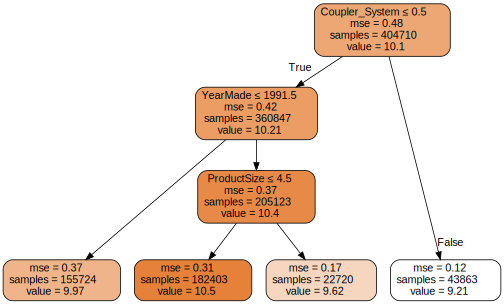

In [32]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

Understanding this picture is one of the best ways to understand decision trees, so we will start at the top and explain each part step by step.
이 그림을 이해하는 것은 의사 결정 트리를 이해하는 가장 좋은 방법 중 하나이므로 맨 위에서 시작하여 각 부분을 단계별로 설명하겠습니다.

The top node represents the *initial model* before any splits have been done, when all the data is in one group. This is the simplest possible model. It is the result of asking zero questions and will always predict the value to be the average value of the whole dataset. In this case, we can see it predicts a value of 10.10 for the logarithm of the sales price. It gives a mean squared error of 0.48. The square root of this is 0.69. (Remember that unless you see `m_rmse`, or a *root mean squared error*, then the value you are looking at is before taking the square root, so it is just the average of the square of the differences.) We can also see that there are 404,710 auction records in this group—that is the total size of our training set. The final piece of information shown here is the decision criterion for the best split that was found, which is to split based on the `coupler_system` column.

최상위 노드는 모든 데이터가 하나의 그룹에있을 때 분할이 완료되기 전의 * 초기 모델 *을 나타냅니다. 이것은 가능한 가장 간단한 모델입니다. 0 질문을 한 결과이며 항상 전체 데이터 세트의 평균 값이 될 값을 예측합니다. 이 경우 판매 가격의 대수에 대해 10.10의 값을 예측할 수 있습니다. 평균 제곱 오차는 0.48입니다. 이것의 제곱근은 0.69입니다. (`m_rmse` 또는 * root mean squared error *가 표시되지 않는 한,보고있는 값은 제곱근을 취하기 전의 값이므로 차이 제곱의 평균 일뿐입니다.) 이 그룹에는 404,710 개의 경매 기록이 있습니다. 즉, 교육 세트의 총 크기입니다. 여기에 표시된 마지막 정보는 발견 된 최상의 분할에 대한 결정 기준이며`coupler_system` 열을 기반으로 분할하는 것입니다.

Moving down and to the left, this node shows us that there were 360,847 auction records for equipment where `coupler_system` was less than 0.5. The average value of our dependent variable in this group is 10.21. Moving down and to the right from the initial model takes us to the records where `coupler_system` was greater than 0.5.

아래로 왼쪽으로 이동하면이 노드는`coupler_system`이 0.5 미만인 장비에 대해 360,847 개의 경매 기록이 있음을 보여줍니다. 이 그룹에서 종속 변수의 평균값은 10.21입니다. 초기 모델에서 오른쪽 아래로 이동하면`coupler_system`이 0.5보다 큰 레코드로 이동합니다.

The bottom row contains our *leaf nodes*: the nodes with no answers coming out of them, because there are no more questions to be answered. At the far right of this row is the node containing records where `coupler_system` was greater than 0.5. The average value here is 9.21, so we can see the decision tree algorithm did find a single binary decision that separated high-value from low-value auction results. Asking only about `coupler_system` predicts an average value of 9.21 versus 10.1.

맨 아래 행에는 * 리프 노드 *가 포함되어 있습니다. 더 이상 답변 할 질문이 없기 때문에 답변이 나오지 않는 노드입니다. 이 행의 맨 오른쪽에는`coupler_system`이 0.5보다 큰 레코드를 포함하는 노드가 있습니다. 여기서 평균 값은 9.21이므로 결정 트리 알고리즘이 높은 값과 낮은 값의 경매 결과를 구분하는 단일 이진 결정을 찾았 음을 알 수 있습니다. `coupler_system`에 대해서만 물어 보면 10.1 대비 평균 9.21 값이 예측됩니다.

Returning back to the top node after the first decision point, we can see that a second binary decision split has been made, based on asking whether `YearMade` is less than or equal to 1991.5. For the group where this is true (remember, this is now following two binary decisions, based on `coupler_system` and `YearMade`) the average value is 9.97, and there are 155,724 auction records in this group. For the group of auctions where this decision is false, the average value is 10.4, and there are 205,123 records. So again, we can see that the decision tree algorithm has successfully split our more expensive auction records into two more groups which differ in value significantly.

첫 번째 결정 지점 이후 최상위 노드로 돌아 가면`YearMade`가 1991.5보다 작거나 같은지 묻는 것에 따라 두 번째 이진 결정 분할이 이루어 졌음을 알 수 있습니다. 이것이 사실 인 그룹의 경우 (이제는`coupler_system`과`YearMade`를 기반으로 한 두 가지 이진 결정을 따른다는 것을 기억하십시오) 평균 값은 9.97이고이 그룹에는 155,724 개의 경매 레코드가 있습니다. 이 결정이 거짓 인 경매 그룹의 경우 평균 값은 10.4이고 205,123 개의 레코드가 있습니다. 다시 말하지만, 의사 결정 트리 알고리즘이 더 비싼 경매 기록을 가치가 크게 다른 두 그룹으로 성공적으로 분할 한 것을 볼 수 있습니다.

We can show the same information using Terence Parr's powerful [dtreeviz](https://explained.ai/decision-tree-viz/) library:

Terence Parr의 강력한 [dtreeviz] (https://explained.ai/decision-tree-viz/) 라이브러리를 사용하여 동일한 정보를 표시 할 수 있습니다.

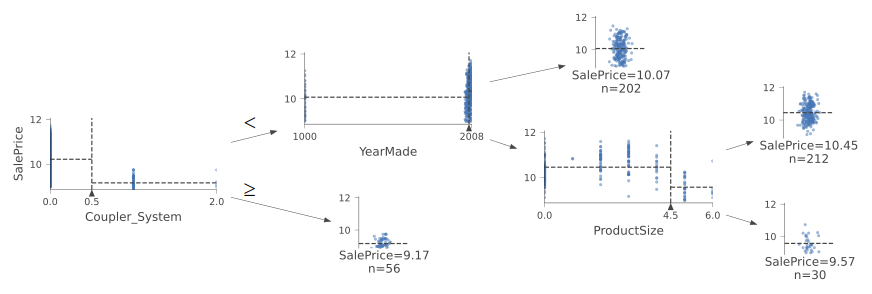

In [33]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

This shows a chart of the distribution of the data for each split point. We can clearly see that there's a problem with our `YearMade` data: there are bulldozers made in the year 1000, apparently! Presumably this is actually just a missing value code (a value that doesn't otherwise appear in the data and that is used as a placeholder in cases where a value is missing). For modeling purposes, 1000 is fine, but as you can see this outlier makes visualization the values we are interested in more difficult. So, let's replace it with 1950:

이것은 각 분할 점에 대한 데이터 분포 차트를 보여줍니다. 우리의 'YearMade'데이터에 문제가 있음을 분명히 알 수 있습니다. 1000 년에 만들어진 불도저가 분명히 있습니다! 아마도 이것은 실제로는 누락 된 값 코드 일뿐입니다 (다른 방법으로는 데이터에 나타나지 않고 값이 누락 된 경우 자리 표시 자로 사용되는 값). 모델링 목적으로 1000은 괜찮지 만이 이상 값은 우리가 관심있는 값의 시각화를 더 어렵게 만듭니다. 그러니 1950으로 바꾸겠습니다.

In [34]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

That change makes the split much clearer in the tree visualization, even although it doesn't actually change the result of the model in any significant way. This is a great example of how resilient decision trees are to data issues!

이러한 변경으로 인해 실제로 모델의 결과가 중요한 방식으로 변경되지는 않지만 트리 시각화에서 분할이 훨씬 더 명확 해집니다. 이것은 데이터 문제에 대한 의사 결정 트리가 얼마나 탄력적인지 보여주는 좋은 예입니다!

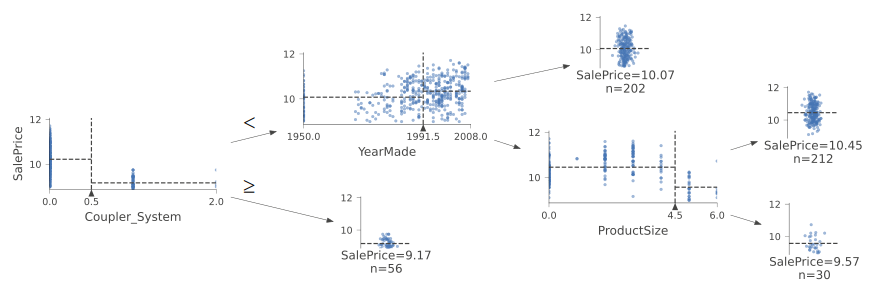

In [35]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as `max_leaf_nodes`:

이제 의사 결정 트리 알고리즘이 더 큰 트리를 작성하도록합시다. 여기서는`max_leaf_nodes`와 같은 중지 기준을 전달하지 않습니다.

In [36]:
m = DecisionTreeRegressor()
m.fit(xs, y);

We'll create a little function to check the root mean squared error of our model (`m_rmse`), since that's how the competition was judged:
우리 모델의 제곱 평균 오차 (`m_rmse`)를 확인하는 작은 함수를 만들 것입니다. 이것이 경쟁이 판단되는 방식이기 때문입니다.

In [37]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [38]:
m_rmse(m, xs, y)

0.0

So, our model is perfect, right? Not so fast... remember we really need to check the validation set, to ensure we're not overfitting:

그래서 우리 모델은 완벽 하죠? 너무 빠르지는 않습니다. 과적 합하지 않도록 유효성 검사 세트를 확인해야합니다.

In [39]:
m_rmse(m, valid_xs, valid_y)

0.331466

Oops—it looks like we might be overfitting pretty badly. Here's why:

죄송합니다. 과적 합 상태가 매우 심할 것 같습니다. 그 이유는 다음과 같습니다.

In [40]:
m.get_n_leaves(), len(xs)

(324544, 404710)

We've got nearly as many leaf nodes as data points! That seems a little over-enthusiastic. Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 auction records:

데이터 포인트만큼 많은 리프 노드가 있습니다! 그것은 약간 지나치게 열정적 인 것 같습니다. 실제로 sklearn의 기본 설정을 사용하면 각 리프 노드에 항목이 하나만있을 때까지 노드 분할을 계속할 수 있습니다. 모든 리프 노드에 최소 25 개의 경매 레코드가 포함되도록 sklearn에 알리도록 중지 규칙을 변경하겠습니다.

In [41]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248562, 0.323396)

That looks much better. Let's check the number of leaves again:

훨씬 좋아 보인다. 잎의 수를 다시 확인해 봅시다.

In [42]:
m.get_n_leaves()

12397

Much more reasonable!

훨씬 더 합리적입니다!

> A: Here's my intuition for an overfitting decision tree with more leaf nodes than data items. Consider the game Twenty Questions. In that game, the chooser secretly imagines an object (like, "our television set"), and the guesser gets to pose 20 yes or no questions to try to guess what the object is (like "Is it bigger than a breadbox?"). The guesser is not trying to predict a numerical value, but just to identify a particular object out of the set of all imaginable objects. When your decision tree has more leaves than there are possible objects in your domain, then it is essentially a well-trained guesser. It has learned the sequence of questions needed to identify a particular data item in the training set, and it is "predicting" only by describing that item's value. This is a way of memorizing the training set—i.e., of overfitting.

> A : 데이터 항목보다 리프 노드가 더 많은 과적 합 의사 결정 트리에 대한 제 직감입니다. 게임 스무 질문을 고려하십시오. 그 게임에서 선택자는 비밀리에 물체 (예 : "우리 텔레비전 세트")를 상상하고, 추측자는 물체가 무엇인지 추측하기 위해 20 개의 예 또는 아니오 질문을 던집니다 (예 : "브래드 박스보다 큰가요?"). ). 추측자는 숫자 값을 예측하는 것이 아니라 상상할 수있는 모든 개체 집합에서 특정 개체를 식별하기위한 것입니다. 의사 결정 트리에 도메인에 가능한 개체가있는 것보다 더 많은 잎이 있으면 본질적으로 잘 훈련 된 추측 자입니다. 학습 세트에서 특정 데이터 항목을 식별하는 데 필요한 일련의 질문을 학습했으며 해당 항목의 값을 설명하는 것만으로 "예측"합니다. 이것은 훈련 세트, 즉 과적 합을 기억하는 방법입니다.

Building a decision tree is a good way to create a model of our data. It is very flexible, since it can clearly handle nonlinear relationships and interactions between variables. But we can see there is a fundamental compromise between how well it generalizes (which we can achieve by creating small trees) and how accurate it is on the training set (which we can achieve by using large trees).

의사 결정 트리를 작성하는 것은 데이터 모델을 만드는 좋은 방법입니다. 비선형 관계와 변수 간의 상호 작용을 명확하게 처리 할 수 있기 때문에 매우 유연합니다. 그러나 우리는 그것이 얼마나 잘 일반화되는지 (작은 나무를 만들어서 얻을 수있는)와 그것이 훈련 세트에서 얼마나 정확한지 (큰 나무를 사용하여 얻을 수있는) 사이에 근본적인 타협이 있음을 알 수 있습니다.

So how do we get the best of both worlds? We'll show you right after we handle an important missing detail: how to handle categorical variables.

그렇다면 우리는 어떻게 두 세계를 최대한 활용할 수 있을까요? 누락 된 중요한 세부 사항을 처리 한 직후에 범주 형 변수를 처리하는 방법을 보여 드리겠습니다.

### Categorical Variables(범주 형 변수)

In the previous chapter, when working with deep learning networks, we dealt with categorical variables by one-hot encoding them and feeding them to an embedding layer. The embedding layer helped the model to discover the meaning of the different levels of these variables (the levels of a categorical variable do not have an intrinsic meaning, unless we manually specify an ordering using Pandas). In a decision tree, we don't have embeddings layers—so how can these untreated categorical variables do anything useful in a decision tree? For instance, how could something like a product code be used?

이전 장에서 딥 러닝 네트워크로 작업 할 때 우리는 범주 형 변수를 원-핫 인코딩하고 임베딩 레이어에 공급하여 다뤘습니다. 임베딩 레이어는 모델이 이러한 변수의 다양한 수준의 의미를 발견하는 데 도움이되었습니다 (Pandas를 사용하여 수동으로 순서를 지정하지 않는 한 범주 형 변수의 수준에는 내재적 의미가 없음). 의사 결정 트리에는 임베딩 레이어가 없습니다. 그러면 이러한 처리되지 않은 범주 형 변수가 의사 결정 트리에서 유용한 작업을 어떻게 수행 할 수 있습니까? 예를 들어, 제품 코드와 같은 것을 어떻게 사용할 수 있습니까?

The short answer is: it just works! Think about a situation where there is one product code that is far more expensive at auction than any other one. In that case, any binary split will result in that one product code being in some group, and that group will be more expensive than the other group. Therefore, our simple decision tree building algorithm will choose that split. Later during training the algorithm will be able to further split the subgroup that contains the expensive product code, and over time, the tree will home in on that one expensive product.

짧은 대답은 바로 작동합니다! 경매에서 다른 어떤 것보다 훨씬 더 비싼 하나의 제품 코드가있는 상황을 생각해보십시오. 이 경우 이진 분할로 인해 하나의 제품 코드가 일부 그룹에 포함되고 해당 그룹은 다른 그룹보다 비용이 많이 듭니다. 따라서 우리의 간단한 의사 결정 트리 구축 알고리즘은 해당 분할을 선택합니다. 나중에 학습하는 동안 알고리즘은 값 비싼 제품 코드를 포함하는 하위 그룹을 추가로 분할 할 수 있으며 시간이 지남에 따라 트리는 값 비싼 제품 하나에 위치합니다.

It is also possible to use one-hot encoding to replace a single categorical variable with multiple one-hot-encoded columns, where each column represents a possible level of the variable. Pandas has a `get_dummies` method which does just that.

원-핫 인코딩을 사용하여 단일 범주 형 변수를 여러 개의 원-핫 인코딩 된 열로 대체 할 수도 있습니다. 여기서 각 열은 변수의 가능한 수준을 나타냅니다. Pandas에는이를 수행하는`get_dummies` 메소드가 있습니다.

However, there is not really any evidence that such an approach improves the end result. So, we generally avoid it where possible, because it does end up making your dataset harder to work with. In 2019 this issue was explored in the paper ["Splitting on Categorical Predictors in Random Forests"](https://peerj.com/articles/6339/) by Marvin Wright and Inke König, which said:

그러나 그러한 접근 방식이 최종 결과를 향상 시킨다는 증거는 실제로 없습니다. 따라서 일반적으로 가능하면 데이터 세트 작업을 더 어렵게 만들기 때문에 피합니다. 2019 년에이 문제는 Marvin Wright와 Inke König의 논문 [ "무작위 숲의 범주 형 예측 자에 대한 분할"] (https://peerj.com/articles/6339/)에서 살펴 보았습니다.

> : The standard approach for nominal predictors is to consider all $2^{k-1} − 1$ 2-partitions of the *k* predictor categories. However, this exponential relationship produces a large number of potential splits to be evaluated, increasing computational complexity and restricting the possible number of categories in most implementations. For binary classification and regression, it was shown that ordering the predictor categories in each split leads to exactly the same splits as the standard approach. This reduces computational complexity because only *k* − 1 splits have to be considered for a nominal predictor with *k* categories.

> : 명목 예측 변수에 대한 표준 접근 방식은 * k * 예측 변수 범주의 모든 $ 2 ^ {k-1} − 1 $ 2- 파티션을 고려하는 것입니다. 그러나 이러한 지수 관계는 평가할 잠재적 분할을 많이 생성하여 계산 복잡성을 증가시키고 대부분의 구현에서 가능한 범주 수를 제한합니다. 이진 분류 및 회귀의 경우 각 분할에서 예측 자 범주를 정렬하면 표준 접근 방식과 정확히 동일한 분할이 발생하는 것으로 나타났습니다. 이것은 * k * 범주가있는 명목 예측 변수에 대해 * k * − 1 분할 만 고려해야하기 때문에 계산 복잡성을 줄입니다.

Now that you understand how decisions tree work, it's time for the best-of-both-worlds solution: random forests.

이제 의사 결정 트리의 작동 방식을 이해 했으므로 이제는 최고의 솔루션 인 랜덤 포레스트를 사용할 때입니다.

## Random Forests

In 1994 Berkeley professor Leo Breiman, one year after his retirement, published a small technical report called ["Bagging Predictors"](https://www.stat.berkeley.edu/~breiman/bagging.pdf), which turned out to be one of the most influential ideas in modern machine learning. The report began:

1994 년에 버클리 교수 인 Leo Breiman은 은퇴 한 지 1 년 만에 [ "Bagging Predictors"] (https://www.stat.berkeley.edu/~breiman/bagging.pdf)라는 작은 기술 보고서를 발표했습니다. 현대 기계 학습에서 가장 영향력있는 아이디어 중 하나입니다. 보고서가 시작되었습니다.

> : Bagging predictors is a method for generating multiple versions of a predictor and using these to get an aggregated predictor. The aggregation averages over the versions... The multiple versions are formed by making bootstrap replicates of the learning set and using these as new learning sets. Tests… show that bagging can give substantial gains in accuracy. The vital element is the instability of the prediction method. If perturbing the learning set can cause significant changes in the predictor constructed, then bagging can improve accuracy.

> : 배깅 예측자는 예측 자의 여러 버전을 생성하고이를 사용하여 집계 된 예측자를 얻는 방법입니다. 버전에 대한 집계 평균 ... 여러 버전은 학습 세트의 부트 스트랩 복제를 만들고이를 새로운 학습 세트로 사용하여 형성됩니다. 테스트를 통해 배깅이 정확도를 크게 높일 수 있음을 보여줍니다. 중요한 요소는 예측 방법의 불안정성입니다. 학습 세트를 교란하면 구성된 예측 변수가 크게 변경 될 수있는 경우 배깅이 정확도를 향상시킬 수 있습니다.

Here is the procedure that Breiman is proposing:

Breiman이 제안하는 절차는 다음과 같습니다.

1. Randomly choose a subset of the rows of your data (i.e., "bootstrap replicates of your learning set").
데이터 행의 하위 집합을 무작위로 선택합니다 (예 : "학습 세트의 부트 스트랩 복제").

1. Train a model using this subset.
이 하위 집합을 사용하여 모델을 훈련시킵니다.

1. Save that model, and then return to step 1 a few times.
해당 모델을 저장 한 다음 1 단계로 몇 번 돌아갑니다.

1. This will give you a number of trained models. To make a prediction, predict using all of the models, and then take the average of each of those model's predictions.
이렇게하면 여러 훈련 된 모델이 제공됩니다. 예측을 수행하려면 모든 모델을 사용하여 예측 한 다음 해당 모델의 각 예측에 대한 평균을 취합니다.

This procedure is known as "bagging." It is based on a deep and important insight: although each of the models trained on a subset of data will make more errors than a model trained on the full dataset, those errors will not be correlated with each other. Different models will make different errors. The average of those errors, therefore, is: zero! So if we take the average of all of the models' predictions, then we should end up with a prediction that gets closer and closer to the correct answer, the more models we have. This is an extraordinary result—it means that we can improve the accuracy of nearly any kind of machine learning algorithm by training it multiple times, each time on a different random subset of the data, and averaging its predictions.

이 절차를 "배깅"이라고합니다. 이는 깊고 중요한 통찰력을 기반으로합니다. 데이터 하위 집합에 대해 훈련 된 각 모델이 전체 데이터 세트에 대해 훈련 된 모델보다 더 많은 오류를 만들지 만 이러한 오류는 서로 상관되지 않습니다. 모델마다 다른 오류가 발생합니다. 따라서 이러한 오류의 평균은 0입니다! 따라서 모든 모델 예측의 평균을 취하면 정답에 가까워지고 더 가까워 질수록 더 많은 모델을 갖게되는 예측으로 끝납니다. 이것은 놀라운 결과입니다. 즉, 데이터의 다른 임의 하위 집합에서 매번 여러 번 훈련하고 예측을 평균화하여 거의 모든 종류의 기계 학습 알고리즘의 정확도를 향상시킬 수 있습니다.

In 2001 Leo Breiman went on to demonstrate that this approach to building models, when applied to decision tree building algorithms, was particularly powerful. He went even further than just randomly choosing rows for each model's training, but also randomly selected from a subset of columns when choosing each split in each decision tree. He called this method the *random forest*. Today it is, perhaps, the most widely used and practically important machine learning method.

2001 년에 Leo Breiman은 의사 결정 트리 구축 알고리즘에 적용될 때 모델 구축에 대한 이러한 접근 방식이 특히 강력하다는 것을 보여주었습니다. 그는 각 모델의 훈련을 위해 행을 무작위로 선택하는 것보다 훨씬 더 나아가 각 의사 결정 트리에서 각 분할을 선택할 때 열의 하위 집합에서 무작위로 선택했습니다. 그는이 방법을 * 랜덤 포레스트 *라고 불렀습니다. 오늘날 아마도 가장 널리 사용되고 실질적으로 중요한 기계 학습 방법 일 것입니다.

In essence a random forest is a model that averages the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters. Bagging is a particular approach to "ensembling," or combining the results of multiple models together. To see how it works in practice, let's get started on creating our own random forest!

본질적으로 랜덤 포레스트는 트리 및 기타 트리 매개 변수를 훈련하는 데 사용되는 데이터를 지정하는 다양한 매개 변수를 무작위로 변경하여 생성되는 많은 의사 결정 트리의 예측을 평균화하는 모델입니다. 배깅은 여러 모델의 결과를 "앙상블 링"하거나 결합하는 특정 접근 방식입니다. 실제로 어떻게 작동하는지 확인하기 위해 우리 자신의 임의의 숲을 만들어 보겠습니다!

In [43]:
#hide
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org  —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

### Creating a Random Forest

We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

의사 결정 트리를 만든 것처럼 임의 포리스트를 만들 수 있습니다. 단, 지금은 포리스트에 있어야하는 트리 수, 데이터 항목 (행)의 하위 집합을 설정하는 방법 및 하위 집합을 설정하는 방법을 나타내는 매개 변수도 지정합니다. 필드 (열).

In the following function definition `n_estimators` defines the number of trees we want, `max_samples` defines how many rows to sample for training each tree, and `max_features` defines how many columns to sample at each split point (where `0.5` means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same `min_samples_leaf` parameter we used in the last section. Finally, we pass `n_jobs=-1` to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

다음 함수 정의에서`n_estimators`는 원하는 트리 수를 정의하고`max_samples`는 각 트리 학습을 위해 샘플링 할 행 수를 정의하고`max_features`는 각 분할 지점에서 샘플링 할 열 수를 정의합니다 ( '0.5'는 "총 열 수의 절반을 차지합니다"). 마지막 섹션에서 사용한 것과 동일한`min_samples_leaf` 매개 변수를 포함하여 트리 노드 분할을 중지 할시기를 지정하여 트리의 깊이를 효과적으로 제한 할 수도 있습니다. 마지막으로`n_jobs = -1`을 전달하여 sklearn에게 모든 CPU를 사용하여 병렬로 트리를 빌드하도록 지시합니다. 이를위한 약간의 기능을 생성함으로써이 장의 나머지 부분에서 다른 변형을 더 빠르게 시도 할 수 있습니다.

In [44]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [45]:
m = rf(xs, y);

Our validation RMSE is now much improved over our last result produced by the `DecisionTreeRegressor`, which made just one tree using all the available data:

유효성 검사 RMSE는 사용 가능한 모든 데이터를 사용하여 하나의 트리 만 만든`DecisionTreeRegressor`에 의해 생성 된 마지막 결과보다 훨씬 향상되었습니다.

In [46]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170917, 0.233975)

One of the most important properties of random forests is that they aren't very sensitive to the hyperparameter choices, such as `max_features`. You can set `n_estimators` to as high a number as you have time to train—the more trees you have, the more accurate the model will be. `max_samples` can often be left at its default, unless you have over 200,000 data points, in which case setting it to 200,000 will make it train faster with little impact on accuracy. `max_features=0.5` and `min_samples_leaf=4` both tend to work well, although sklearn's defaults work well too.

랜덤 포레스트의 가장 중요한 속성 중 하나는`max_features`와 같은 하이퍼 파라미터 선택에 매우 민감하지 않다는 것입니다. 훈련 할 시간이있는만큼`n_estimators`를 설정할 수 있습니다. 트리가 많을수록 모델이 더 정확 해집니다. 'max_samples'는 데이터 포인트가 200,000 개를 초과하지 않는 한 기본값으로 두는 경우가 많습니다.이 경우 200,000으로 설정하면 정확도에 거의 영향을주지 않고 빠르게 학습됩니다. `max_features = 0.5` 및`min_samples_leaf = 4`는 모두 잘 작동하는 경향이 있지만 sklearn의 기본값도 잘 작동합니다.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of the effects different `max_features` choices, with increasing numbers of trees. In the plot, the blue plot line uses the fewest features and the green line uses the most (it uses all the features). As you can see in <<max_features>>, the models with the lowest error result from using a subset of features but with a larger number of trees.

sklearn 문서 [예제보기] (http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)는 다양한`max_features` 선택에 대한 영향을 트리 수 증가와 함께 나타냅니다. 그림에서 파란색 그림 선은 가장 적은 특성을 사용하고 녹색 선은 가장 많은 특성을 사용합니다 (모든 특성을 사용함). << max_features >>에서 볼 수 있듯이 오류가 가장 낮은 모델은 기능의 하위 집합을 사용하지만 많은 수의 트리를 사용하여 발생합니다.

<img alt="sklearn max_features chart" width="500" caption="Error based on max features and number of trees (source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)" src="images/sklearn_features.png" id="max_features"/>

To see the impact of `n_estimators`, let's get the predictions from each individual tree in our forest (these are in the `estimators_` attribute):

`n_estimators`의 영향을 확인하기 위해 포리스트의 각 개별 트리에서 예측을 가져옵니다 ( 'estimators_` 속성에 있음).

In [47]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

As you can see, `preds.mean(0)` gives the same results as our random forest:

보시다시피`preds.mean (0)`은 랜덤 포레스트와 동일한 결과를 제공합니다.

In [48]:
r_mse(preds.mean(0), valid_y)

0.233975

Let's see what happens to the RMSE as we add more and more trees. As you can see, the improvement levels off quite a bit after around 30 trees:

더 많은 나무를 추가함에 따라 RMSE에 어떤 일이 발생하는지 보겠습니다. 보시다시피, 약 30 그루의 나무 이후 개선 수준이 상당히 낮아졌습니다.

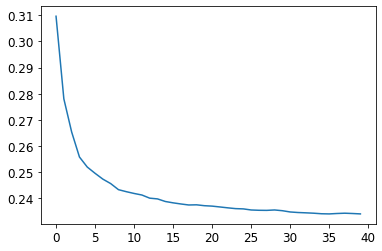

In [49]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both? With the existing information we've seen, we can't tell. However, random forests have a very clever trick called *out-of-bag* (OOB) error that can help us with this (and more!).

검증 세트의 성능이 훈련 세트보다 나쁩니다. 그러나 그것은 우리가 과적 합했기 때문입니까, 아니면 검증 세트가 다른 기간을 포함하기 때문입니까, 아니면 둘 다일까요? 우리가 본 기존 정보로는 말할 수 없습니다. 그러나 랜덤 포레스트에는 * OOB (out-of-bag *) 오류라는 매우 영리한 트릭이있어이 문제를 해결할 수 있습니다.

### Out-of-Bag Error

Recall that in a random forest, each tree is trained on a different subset of the training data. The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was *not* included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.

랜덤 포레스트에서 각 트리는 훈련 데이터의 다른 하위 집합에 대해 훈련됩니다. OOB 오류는 해당 행이 학습에 포함되지 * 않은 * 행의 오류 트리 계산에만 포함하여 학습 세트에 대한 예측 오류를 측정하는 방법입니다. 이를 통해 별도의 검증 세트 없이도 모델이 과적 합되었는지 여부를 확인할 수 있습니다.

> A: My intuition for this is that, since every tree was trained with a different randomly selected subset of rows, out-of-bag error is a little like imagining that every tree therefore also has its own validation set. That validation set is simply the rows that were not selected for that tree's training.

> A : 내 직관은 모든 트리가 무작위로 선택된 행의 다른 하위 집합으로 훈련 되었기 때문에 out-of-bag 오류는 모든 트리에도 자체 검증 세트가 있다고 상상하는 것과 비슷하다는 것입니다. 해당 검증 세트는 단순히 해당 트리의 훈련을 위해 선택되지 않은 행입니다.

This is particularly beneficial in cases where we have only a small amount of training data, as it allows us to see whether our model generalizes without removing items to create a validation set. The OOB predictions are available in the `oob_prediction_` attribute. Note that we compare them to the training labels, since this is being calculated on trees using the training set.

이는 학습 데이터가 적은 경우에 특히 유용합니다. 검증 세트를 생성하기 위해 항목을 제거하지 않고도 모델이 일반화되는지 여부를 확인할 수 있기 때문입니다. OOB 예측은 ʻoob_prediction_` 속성에서 사용할 수 있습니다. 훈련 세트를 사용하여 트리에서 계산되므로 훈련 레이블과 비교합니다.

In [50]:
r_mse(m.oob_prediction_, y)

0.210681

We can see that our OOB error is much lower than our validation set error. This means that something else is causing that error, in *addition* to normal generalization error. We'll discuss the reasons for this later in this chapter.

OOB 오류가 검증 세트 오류보다 훨씬 낮다는 것을 알 수 있습니다. 이것은 정규 일반화 오류에 * 추가 *하여 다른 것이 오류를 유발하고 있음을 의미합니다. 이에 대한 이유는이 장의 뒷부분에서 설명하겠습니다.

This is one way to interpret our model's predictions—let's focus on more of those now.

이것은 모델의 예측을 해석하는 한 가지 방법입니다. 이제 더 많은 것에 초점을 맞추겠습니다.

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:
표 형식 데이터의 경우 모델 해석이 특히 중요합니다. 주어진 모델에 대해 우리가 가장 관심을 가질만한 것은 다음과 같습니다.

- How confident are we in our predictions using a particular row of data?
특정 데이터 행을 사용한 예측에 얼마나 확신이 있습니까?

- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
특정 데이터 행으로 예측할 때 가장 중요한 요소는 무엇이며 해당 예측에 어떤 영향을 주었습니까?

- Which columns are the strongest predictors, which can we ignore?
어떤 열이 가장 강력한 예측 변수이며 무시할 수 있습니까?

- Which columns are effectively redundant with each other, for purposes of prediction?
예측을 위해 어떤 열이 서로 효과적으로 중복됩니까?

- How do predictions vary, as we vary these columns?
이러한 열을 변경함에 따라 예측은 어떻게 달라 집니까?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!
앞으로 보 겠지만, 랜덤 포레스트는 이러한 질문에 답하는 데 특히 적합합니다. 첫 번째부터 시작하겠습니다!

### Tree Variance for Prediction Confidence(예측 신뢰도에 대한 나무 분산)

We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the *relative* confidence of predictions. In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).

우리는 모델이 개별 트리의 예측을 평균하여 전체 예측, 즉 값 추정치를 얻는 방법을 보았습니다. 하지만 추정치의 신뢰도를 어떻게 알 수 있습니까? 한 가지 간단한 방법은 평균 대신 트리 전체에서 예측의 표준 편차를 사용하는 것입니다. 이것은 예측의 * 상대적 * 신뢰도를 알려줍니다. 일반적으로 나무가 더 일관된 (낮은 표준 편차) 경우에 비해 매우 다른 결과 (높은 표준 편차)를 제공하는 행에 대한 결과를 사용하는 데 더주의를 기울여야합니다.

In the earlier section on creating a random forest, we saw how to get predictions over the validation set, using a Python list comprehension to do this for each tree in the forest:

임의 포리스트 생성에 대한 이전 섹션에서 Python 목록 이해를 사용하여 포리스트의 각 트리에 대해이를 수행하여 유효성 검사 집합에 대한 예측을 얻는 방법을 보았습니다.

In [51]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [52]:
preds.shape

(40, 7988)

Now we have a prediction for every tree and every auction (40 trees and 7,988 auctions) in the validation set.
이제 우리는 검증 세트의 모든 나무와 모든 경매 (40 나무와 7,988 경매)에 대한 예측을 가지고 있습니다.

Using this we can get the standard deviation of the predictions over all the trees, for each auction:
이를 사용하여 각 경매에 대해 모든 트리에 대한 예측의 표준 편차를 얻을 수 있습니다.

In [53]:
preds_std = preds.std(0)

Here are the standard deviations for the predictions for the first five auctions—that is, the first five rows of the validation set:

다음은 처음 5 개 경매, 즉 유효성 검사 세트의 처음 5 개 행에 대한 예측의 표준 편차입니다.

In [54]:
preds_std[:5]

array([0.25065395, 0.11043862, 0.08242067, 0.26988508, 0.15730173])

As you can see, the confidence in the predictions varies widely. For some auctions, there is a low standard deviation because the trees agree. For others it's higher, as the trees don't agree. This is information that would be useful in a production setting; for instance, if you were using this model to decide what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

보시다시피 예측의 신뢰도는 매우 다양합니다. 일부 경매의 경우 나무가 동의하기 때문에 표준 편차가 낮습니다. 다른 사람들에게는 나무가 동의하지 않기 때문에 더 높습니다. 이것은 생산 환경에서 유용한 정보입니다. 예를 들어이 모델을 사용하여 경매에서 입찰 할 항목을 결정하는 경우 신뢰도가 낮은 예측으로 인해 입찰하기 전에 항목을 더주의 깊게 살펴볼 수 있습니다.

### Feature Importance(기능 중요성)

It's not normally enough to just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

일반적으로 모델이 정확한 예측을 할 수 있다는 것을 아는 것만으로는 충분하지 않습니다. 또한 모델이 예측을 * 어떻게 *하는지도 알고 싶습니다. * 기능 중요성 *은 이에 대한 통찰력을 제공합니다. `feature_importances_` 속성을 살펴보면 sklearn의 랜덤 포레스트에서 직접 가져올 수 있습니다. 다음은이를 DataFrame에 넣고 정렬하는 데 사용할 수있는 간단한 함수입니다.

In [55]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) `YearMade` and `ProductSize` being at the top of the list:

우리 모델의 기능 중요성은 처음 몇 개의 가장 중요한 열이 나머지 열보다 훨씬 더 높은 중요도 점수를 가지고 있음을 보여줍니다. (놀랍지는 않지만)`YearMade` 및`ProductSize`가 목록의 맨 위에 있습니다.

In [56]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
59,YearMade,0.180070
7,ProductSize,0.113915
31,Coupler_System,0.104699
8,fiProductClassDesc,0.064118
33,Hydraulics_Flow,0.059110
56,ModelID,0.059087
51,saleElapsed,0.051231
4,fiSecondaryDesc,0.041778
32,Grouser_Tracks,0.037560
2,fiModelDesc,0.030933


A plot of the feature importances shows the relative importances more clearly:
기능 중요도 플롯은 상대적 중요도를보다 명확하게 보여줍니다.

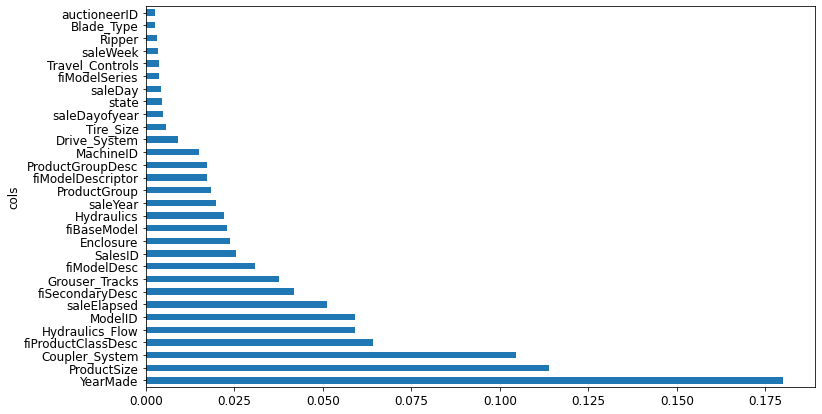

In [57]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

이러한 중요성을 계산하는 방법은 매우 간단하면서도 우아합니다. 기능 중요도 알고리즘은 각 트리를 반복 한 다음 각 분기를 재귀 적으로 탐색합니다. 각 지점에서 해당 분할에 사용 된 기능과 해당 분할의 결과로 모델이 얼마나 개선되었는지 확인합니다. 개선 (해당 그룹의 행 수에 따라 가중치가 부여됨)이 해당 기능의 중요도 점수에 추가됩니다. 이것은 모든 나무의 모든 가지에 걸쳐 합산되고 마지막으로 점수가 1이되도록 정규화됩니다.

### Removing Low-Importance Variables(중요도가 낮은 변수 제거)

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

중요도가 낮은 변수를 제거하여 열의 하위 집합 만 사용하고 여전히 좋은 결과를 얻을 수있는 것 같습니다. 기능 중요도가 0.005보다 큰 항목을 유지해 보겠습니다.

In [58]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

We can retrain our model using just this subset of the columns:

다음 열 하위 집합 만 사용하여 모델을 다시 훈련 할 수 있습니다.

In [59]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [60]:
m = rf(xs_imp, y)

And here's the result:

결과는 다음과 같습니다.

In [61]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181204, 0.230329)

Our accuracy is about the same, but we have far fewer columns to study:

정확도는 거의 동일하지만 연구 할 열이 훨씬 적습니다.

In [62]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

We've found that generally the first step to improving a model is simplifying it—78 columns was too many for us to study them all in depth! Furthermore, in practice often a simpler, more interpretable model is easier to roll out and maintain.

This also makes our feature importance plot easier to interpret. Let's look at it again:

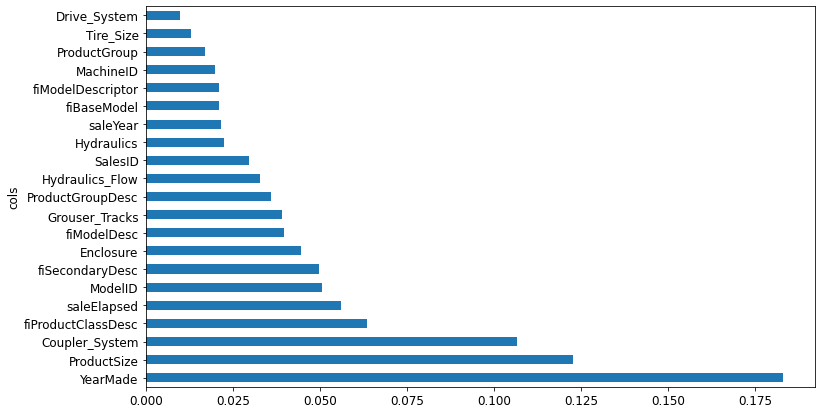

In [63]:
plot_fi(rf_feat_importance(m, xs_imp));

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, `ProductGroup` and `ProductGroupDesc`. Let's try to remove any redundent features. 

일반적으로 모델을 개선하는 첫 번째 단계는 모델을 단순화하는 것입니다. 78 개의 열이 너무 많아서 모두 심도있게 연구 할 수 없었습니다! 또한 실제로는 더 간단하고 해석 가능한 모델이 출시 및 유지 관리가 더 쉽습니다.

### Removing Redundant Features(중복 기능 제거)

Let's start with:

시작해 보겠습니다.

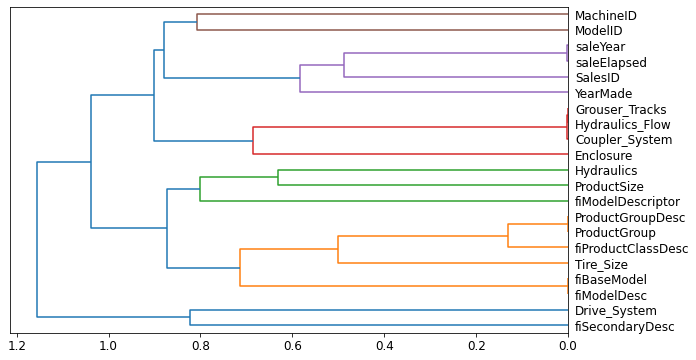

In [64]:
cluster_columns(xs_imp)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. Unsurprisingly, the fields `ProductGroup` and `ProductGroupDesc` were merged quite early, as were `saleYear` and `saleElapsed` and `fiModelDesc` and `fiBaseModel`. These might be so closely correlated they are practically synonyms for each other.

이 차트에서 가장 유사한 열 쌍은 왼쪽 트리의 "루트"에서 멀리 떨어진 초기에 함께 병합 된 열 쌍입니다. 당연히`ProductGroup`과`ProductGroupDesc` 필드는`saleYear`,`saleElapsed`,`fiModelDesc` 및`fiBaseModel`과 같이 아주 일찍 병합되었습니다. 이것들은 매우 밀접하게 연관되어있을 수 있으며 실제로 서로 동의어입니다.

> note: Determining Similarity: The most similar pairs are found by calculating the _rank correlation_, which means that all the values are replaced with their _rank_ (i.e., first, second, third, etc. within the column), and then the _correlation_ is calculated. (Feel free to skip over this minor detail though, since it's not going to come up again in the book!)

> 참고 : 유사성 결정 : _rank correlation_을 계산하여 가장 유사한 쌍을 찾습니다. 즉, 모든 값이 해당 _rank_ (즉, 열 내에서 첫 번째, 두 번째, 세 번째 등)로 대체 된 다음 _correlation_은 계획된. (책에 다시 나오지 않을 것이므로이 사소한 세부 사항은 건너 뛰어도됩니다!)

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. (In statistics it's called *R^2*, although the details aren't important for this explanation.) We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

정확도에 영향을주지 않고 모델을 단순화 할 수 있는지 확인하기 위해 밀접하게 관련된 기능 중 일부를 제거해 보겠습니다. 먼저, 더 낮은`max_samples`와 더 높은`min_samples_leaf`를 사용하여 랜덤 포레스트를 빠르게 훈련시키고 OOB 점수를 반환하는 함수를 만듭니다. OOB 점수는 sklearn에서 반환하는 숫자로 완벽한 모델의 경우 1.0에서 임의 모델의 경우 0.0 사이입니다. (통계에서는 * R ^ 2 *라고합니다.이 설명에 대한 세부 정보는 중요하지 않습니다.) 매우 정확할 필요는 없습니다. 제거를 기반으로 여러 모델을 비교하는 데 사용할 것입니다. 중복 가능성이있는 일부 열 :

In [65]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Here's our baseline:

기준은 다음과 같습니다.

In [66]:
get_oob(xs_imp)

0.8768243241012634

Now we try removing each of our potentially redundant variables, one at a time:

이제 중복 가능성이있는 각 변수를 한 번에 하나씩 제거하려고합니다.

In [67]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8766429216799364,
 'saleElapsed': 0.8725120463477113,
 'ProductGroupDesc': 0.8773289113713139,
 'ProductGroup': 0.8768277447901079,
 'fiModelDesc': 0.8760365396140016,
 'fiBaseModel': 0.8769194097714894,
 'Hydraulics_Flow': 0.8775975083138958,
 'Grouser_Tracks': 0.8780246481379101,
 'Coupler_System': 0.8780158691125818}

Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier. Let's see what that does:

이제 여러 변수를 삭제 해 보겠습니다. 이전에 발견 한 단단히 정렬 된 각 쌍에서 하나를 삭제합니다. 그것이 무엇을하는지 보자 :

In [68]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8747772191306009

Looking good! This is really not much worse than the model with all the fields. Let's create DataFrames without these columns, and save them:

좋아 보여! 이것은 모든 필드가있는 모델보다 훨씬 나쁘지 않습니다. 이러한 열없이 DataFrames를 만들고 저장해 보겠습니다.

In [69]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [70]:
(path/'xs_final.pkl').save(xs_final)
(path/'valid_xs_final.pkl').save(valid_xs_final)

We can load them back later with:

나중에 다음을 사용하여 다시로드 할 수 있습니다.

In [71]:
xs_final = (path/'xs_final.pkl').load()
valid_xs_final = (path/'valid_xs_final.pkl').load()

Now we can check our RMSE again, to confirm that the accuracy hasn't substantially changed.

이제 RMSE를 다시 확인하여 정확도가 크게 변경되지 않았는지 확인할 수 있습니다.

In [72]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183426, 0.231894)

By focusing on the most important variables, and removing some redundant ones, we've greatly simplified our model. Now, let's see how those variables affect our predictions using partial dependence plots.

가장 중요한 변수에 집중하고 중복 된 변수를 제거하여 모델을 크게 단순화했습니다. 이제 부분 의존도를 사용하여 이러한 변수가 예측에 어떻게 영향을 미치는지 살펴 보겠습니다.

### Partial Dependence(부분 의존)

As we've seen, the two most important predictors are `ProductSize` and `YearMade`. We'd like to understand the relationship between these predictors and sale price. It's a good idea to first check the count of values per category (provided by the Pandas `value_counts` method), to see how common each category is:

지금까지 살펴본 것처럼 가장 중요한 두 가지 예측 변수는`ProductSize`와`YearMade`입니다. 이러한 예측 변수와 판매 가격 간의 관계를 이해하고 싶습니다. 먼저 범주 당 값의 개수 (Pandas`value_counts` 메소드에서 제공)를 확인하여 각 범주가 얼마나 일반적인지 확인하는 것이 좋습니다.

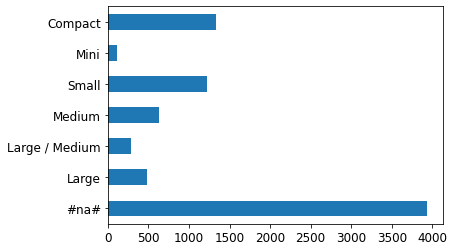

In [73]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

The largrest group is `#na#`, which is the label fastai applies to missing values.

가장 큰 그룹은 fastai가 결 측값에 적용되는 레이블 인`# na #`입니다.

Let's do the same thing for `YearMade`. Since this is a numeric feature, we'll need to draw a histogram, which groups the year values into a few discrete bins:

'YearMade'에 대해서도 같은 작업을합시다. 이것은 숫자 기능이므로 연도 값을 몇 개의 개별 빈으로 그룹화하는 히스토그램을 그려야합니다.

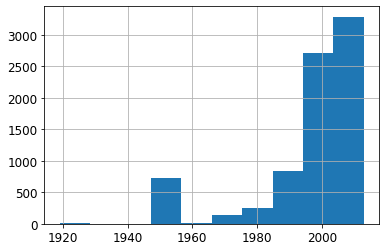

In [74]:
ax = valid_xs_final['YearMade'].hist()

Other than the special value 1950 which we used for coding missing year values, most of the data is from after 1990.
결측 연도 값을 코딩하는 데 사용한 특수 값 1950을 제외하고 대부분의 데이터는 1990 년 이후의 데이터입니다.

Now we're ready to look at *partial dependence plots*. Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?
이제 * 부분 의존도 *를 살펴볼 준비가되었습니다. 부분 의존성 도표는 질문에 답하려고합니다. 행이 문제의 특징 외에 다른 것이없는 경우 종속 변수에 어떤 영향을 미칠까요?

For instance, how does `YearMade` impact sale price, all other things being equal?
예를 들어 'YearMade'가 판매 가격에 어떤 영향을 미치고 다른 모든 요소는 동일할까요?

To answer this question, we can't just take the average sale price for each `YearMade`. The problem with that approach is that many other things vary from year to year as well, such as which products are sold, how many products have air-conditioning, inflation, and so forth. So, merely averaging over all the auctions that have the same `YearMade` would also capture the effect of how every other field also changed along with `YearMade` and how that overall change affected price.

이 질문에 답하기 위해 우리는 각 'YearMade'의 평균 판매 가격을 취할 수 없습니다. 이러한 접근 방식의 문제점은 판매되는 제품, 에어컨이있는 제품, 인플레이션 등과 같은 다른 많은 것들이 해마다 달라진다는 것입니다. 따라서 동일한 'YearMade'가있는 모든 경매에 대해 평균화하는 것만으로도 다른 모든 필드가 'YearMade'와 함께 어떻게 변경되었는지, 그리고 전체적인 변경이 가격에 미치는 영향을 포착 할 수 있습니다.

Instead, what we do is replace every single value in the `YearMade` column with 1950, and then calculate the predicted sale price for every auction, and take the average over all auctions. Then we do the same for 1951, 1952, and so forth until our final year of 2011. This isolates the effect of only `YearMade` (even if it does so by averaging over some imagined records where we assign a `YearMade` value that might never actually exist alongside some other values). 

대신 'YearMade'열의 모든 단일 값을 1950으로 대체 한 다음 모든 경매에 대한 예상 판매 가격을 계산하고 모든 경매에서 평균을 취합니다. 그런 다음 2011 년 마지막 해까지 1951 년, 1952 년 등을 동일하게 수행합니다. 이는 'YearMade'의 효과 만 분리합니다 (해당하는 'YearMade'값을 할당하는 일부 가상 레코드에 대해 평균을 낸 경우에도). 실제로는 다른 값과 함께 존재하지 않을 수도 있습니다.)

> A: If you are philosophically minded it is somewhat dizzying to contemplate the different kinds of hypotheticality that we are juggling to make this calculation. First, there's the fact that _every_ prediction is hypothetical, because we are not noting empirical data. Second, there's the point that we're _not_ merely interested in asking how sale price would change if we changed `YearMade` and everything else along with it. Rather, we're very specifically asking, how sale price would change in a hypothetical world where only `YearMade` changed. Phew! It is impressive that we can ask such questions. I recommend Judea Pearl and Dana Mackenzie's recent book on causality, _The Book of Why_ (Basic Books), if you're interested in more deeply exploring formalisms for analyzing these subtleties.

> A : 만약 당신이 철학적으로 생각한다면 우리가이 계산을하기 위해 저글링하고있는 다양한 종류의 가설을 고려하는 것은 다소 어지럽습니다. 첫째, _every_ 예측이 가설이라는 사실이 있습니다. 왜냐하면 우리는 경험적 데이터에 주목하지 않기 때문입니다. 둘째, 우리가 'YearMade'와 그와 함께 다른 모든 것을 변경하면 판매 가격이 어떻게 변할지 묻는 것에 만 관심이 _ 아니다 _. 오히려 우리는 'YearMade'만 변경된 가상 세계에서 판매 가격이 어떻게 변할지 매우 구체적으로 묻습니다. 휴! 그런 질문을 할 수 있다는 것이 인상적입니다. 이러한 미묘함을 분석하기 위해 형식주의를 더 깊이 탐구하는 데 관심이 있다면 Judea Pearl과 Dana Mackenzie의 인과성에 관한 최근 책 _The Book of Why_ (Basic Books)를 추천합니다.

With these averages, we can then plot each of these years on the x-axis, and each of the predictions on the y-axis. This, finally, is a partial dependence plot. Let's take a look:

이러한 평균을 사용하여 각 연도를 x 축에 플로팅하고 각 예측을 y 축에 플로팅 할 수 있습니다. 이것은 마지막으로 부분 의존성 플롯입니다. 한 번 보자:

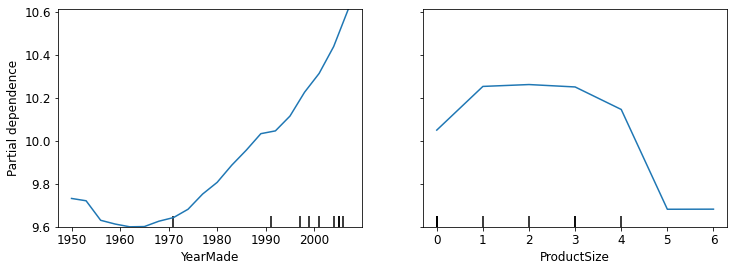

In [75]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

Looking first of all at the `YearMade` plot, and specifically at the section covering the years after 1990 (since as we noted this is where we have the most data), we can see a nearly linear relationship between year and price. Remember that our dependent variable is after taking the logarithm, so this means that in practice there is an exponential increase in price. This is what we would expect: depreciation is generally recognized as being a multiplicative factor over time, so, for a given sale date, varying year made ought to show an exponential relationship with sale price.

먼저 'YearMade'플롯, 특히 1990 년 이후 몇 년간 (우리가 가장 많은 데이터를 보유한 곳임을 언급 했으므로) 섹션을 살펴보면 연도와 가격 간의 거의 선형 관계를 볼 수 있습니다. 우리의 종속 변수는 로그를 취한 후이므로 실제로 가격이 기하 급수적으로 증가한다는 것을 의미합니다. 이것이 우리가 기대하는 것입니다. 감가 상각은 일반적으로 시간이 지남에 따라 곱셈 요소로 인식되므로 주어진 판매 날짜에 대해 다양한 연도는 판매 가격과 기하 급수적 인 관계를 보여야합니다.

The `ProductSize` partial plot is a bit concerning. It shows that the final group, which we saw is for missing values, has the lowest price. To use this insight in practice, we would want to find out *why* it's missing so often, and what that *means*. Missing values can sometimes be useful predictors—it entirely depends on what causes them to be missing. Sometimes, however, they can indicate *data leakage*.

`ProductSize` 부분 플롯은 약간 관련이 있습니다. 결 측값에 대한 최종 그룹의 가격이 가장 낮음을 보여줍니다. 이 통찰력을 실제로 사용하기 위해 우리는 * 이유 *가 너무 자주 누락되는 이유와 * 의미 *를 알아 내고 싶습니다. 누락 된 값은 때로 유용한 예측 변수가 될 수 있습니다. 전적으로 값이 누락되는 원인에 따라 다릅니다. 그러나 때로는 * 데이터 유출 *을 나타낼 수 있습니다.

### Data Leakage(데이터 유출)

In  the paper ["Leakage in Data Mining: Formulation, Detection, and Avoidance"](https://dl.acm.org/doi/10.1145/2020408.2020496), Shachar Kaufman, Saharon Rosset, and Claudia Perlich describe leakage as: 

[ "데이터 마이닝의 누출 : 공식화, 탐지 및 회피"] (https://dl.acm.org/doi/10.1145/2020408.2020496) 논문에서 Shachar Kaufman, Saharon Rosset 및 Claudia Perlich는 누출을 다음과 같이 설명합니다.

> : The introduction of information about the target of a data mining problem, which should not be legitimately available to mine from. A trivial example of leakage would be a model that uses the target itself as an input, thus concluding for example that 'it rains on rainy days'. In practice, the introduction of this illegitimate information is unintentional, and facilitated by the data collection, aggregation and preparation process.

> : 데이터 마이닝 문제의 대상에 대한 정보를 소개하는 것으로 합법적으로 마이닝 할 수 없어야합니다. 누출의 사소한 예는 대상 자체를 입력으로 사용하는 모델이 될 수 있으며, 예를 들어 '비오는 날 비가 내린다'는 결론을 내릴 수 있습니다. 실제로 이러한 불법 정보의 도입은 의도하지 않은 것이며 데이터 수집, 집계 및 준비 프로세스에 의해 촉진됩니다.

They give as an example:
예를 들면 다음과 같습니다.

> : A real-life business intelligence project at IBM where potential customers for certain products were identified, among other things, based on keywords found on their websites. This turned out to be leakage since the website content used for training had been sampled at the point in time where the potential customer has already become a customer, and where the website contained traces of the IBM products purchased, such as the word 'Websphere' (e.g., in a press release about the purchase or a specific product feature the client uses).

> : IBM의 실제 비즈니스 인텔리전스 프로젝트로, 웹 사이트에서 찾은 키워드를 기반으로 특정 제품의 잠재 고객을 식별했습니다. 교육에 사용 된 웹 사이트 콘텐츠가 잠재 고객이 이미 고객이 된 시점에서 샘플링되었으며 웹 사이트에 'Websphere'라는 단어와 같은 구매 한 IBM 제품의 흔적이 포함되어 있기 때문에 이는 유출로 판명되었습니다. (예 : 구매 또는 고객이 사용하는 특정 제품 기능에 대한 보도 자료).

Data leakage is subtle and can take many forms. In particular, missing values often represent data leakage.

데이터 유출은 미묘하며 다양한 형태를 취할 수 있습니다. 특히 누락 된 값은 종종 데이터 유출을 나타냅니다.

For instance, Jeremy competed in a Kaggle competition designed to predict which researchers would end up receiving research grants. The information was provided by a university and included thousands of examples of research projects, along with information about the researchers involved and data on whether or not each grant was eventually accepted. The university hoped to be able to use the models developed in this competition to rank which grant applications were most likely to succeed, so it could prioritize its processing.

예를 들어, Jeremy는 연구 보조금을 받게 될 연구원을 예측하기 위해 고안된 Kaggle 대회에서 경쟁했습니다. 이 정보는 대학에서 제공했으며 관련 연구자에 대한 정보와 각 보조금이 최종 승인되었는지 여부에 대한 데이터와 함께 수천 개의 연구 프로젝트 사례가 포함되었습니다. 대학은이 대회에서 개발 된 모델을 사용하여 어떤 보조금 신청이 성공할 가능성이 가장 높은지 순위를 매길 수 있기를 바랐으므로 처리 우선 순위를 정할 수있었습니다.

Jeremy used a random forest to model the data, and then used feature importance to find out which features were most predictive. He noticed three surprising things:

Jeremy는 랜덤 포레스트를 사용하여 데이터를 모델링 한 다음 기능 중요도를 사용하여 가장 예측 가능한 기능을 알아 냈습니다. 그는 세 가지 놀라운 사실을 발견했습니다.

- The model was able to correctly predict who would receive grants over 95% of the time.
이 모델은 누가 95 %의 시간 동안 보조금을받을 것인지 정확하게 예측할 수있었습니다.

- Apparently meaningless identifier columns were the most important predictors.
무의미한 식별자 열이 가장 중요한 예측 변수였습니다.

- The day of week and day of year columns were also highly predictive; for instance, the vast majority of grant applications dated on a Sunday were accepted, and many accepted grant applications were dated on January 1.
요일 및 연중 열도 예측 가능성이 높았습니다. 예를 들어, 일요일에 제출 된 보조금 신청의 대부분이 수락되었고 많은 승인 된 보조금 신청이 1 월 1 일에 제출되었습니다.

For the identifier columns, one partial dependence plot per column showed that when the information was missing the application was almost always rejected. It turned out that in practice, the university only filled out much of this information *after* a grant application was accepted. Often, for applications that were not accepted, it was just left blank. Therefore, this information was not something that was actually available at the time that the application was received, and it would not be available for a predictive model—it was data leakage.
식별자 열의 경우 열당 하나의 부분 종속성 플롯은 정보가 누락되었을 때 신청이 거의 항상 거부되었음을 보여줍니다. 실제로 대학은 보조금 신청서가 승인 된 후 *이 정보의 대부분을 작성했습니다. 종종 승인되지 않은 신청서의 경우 공백으로 남겨 두었습니다. 따라서이 정보는 응용 프로그램을받을 당시 실제로 사용할 수 없었던 정보가 아니었고 예측 모델에 사용할 수 없었습니다. 데이터 유출이었습니다.

In the same way, the final processing of successful applications was often done automatically as a batch at the end of the week, or the end of the year. It was this final processing date which ended up in the data, so again, this information, while predictive, was not actually available at the time that the application was received.
같은 방식으로 성공적인 애플리케이션의 최종 처리는 종종 주말 또는 연말에 일괄 처리로 자동 수행되었습니다. 이 최종 처리 날짜가 데이터에 포함 되었기 때문에이 정보는 예측 적이지만 신청서를 받았을 때 실제로 사용할 수 없었습니다.

This example showcases the most practical and simple approaches to identifying data leakage, which are to build a model and then:
이 예제는 모델을 구축 한 후 다음과 같은 데이터 유출을 식별하는 가장 실용적이고 간단한 접근 방식을 보여줍니다.

- Check whether the accuracy of the model is *too good to be true*.
모델의 정확도가 * 너무 좋아서 사실이 아닌지 확인하십시오 *.

- Look for important predictors that don't make sense in practice.
실제로 말이되지 않는 중요한 예측 변수를 찾으십시오.

- Look for partial dependence plot results that don't make sense in practice.
실제로는 의미가없는 부분 종속성 플롯 결과를 찾습니다.

Thinking back to our bear detector, this mirrors the advice that we provided in <<chapter_production>>—it is often a good idea to build a model first and then do your data cleaning, rather than vice versa. The model can help you identify potentially problematic data issues.
곰 탐지기를 다시 생각해 보면 << chapter_production >>에서 제공 한 조언을 반영합니다. 모델을 먼저 빌드 한 다음 데이터를 정리하는 것이 좋습니다. 그 반대의 경우도 마찬가지입니다. 이 모델은 잠재적으로 문제가있는 데이터 문제를 식별하는 데 도움이 될 수 있습니다.

It can also help you identifyt which factors influence specific predictions, with tree interpreters.
또한 트리 해석기를 사용하여 특정 예측에 영향을 미치는 요인을 식별하는 데 도움이 될 수 있습니다.

### Tree Interpreter(나무 통역사)

In [76]:
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org  treeinterpreter waterfallcharts

In [77]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

At the start of this section, we said that we wanted to be able to answer five questions:
이 섹션의 시작 부분에서 우리는 다섯 가지 질문에 답할 수 있기를 원한다고 말했습니다.

- How confident are we in our predictions using a particular row of data?
특정 데이터 행을 사용한 예측에 얼마나 확신이 있습니까?

- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
특정 데이터 행으로 예측할 때 가장 중요한 요소는 무엇이며 해당 예측에 어떤 영향을 주었습니까?

- Which columns are the strongest predictors?
가장 강력한 예측 변수는 무엇입니까?

- Which columns are effectively redundant with each other, for purposes of prediction?
예측을 위해 어떤 열이 서로 효과적으로 중복됩니까?

- How do predictions vary, as we vary these columns?
이러한 열을 변경함에 따라 예측은 어떻게 달라 집니까?

We've handled four of these already; only the second question remains. To answer this question, we need to use the `treeinterpreter` library. We'll also use the `waterfallcharts` library to draw the chart of the results.
우리는 이미 이들 중 4 개를 처리했습니다. 두 번째 질문 만 남습니다. 이 질문에 답하려면`treeinterpreter` 라이브러리를 사용해야합니다. 또한`waterfallcharts` 라이브러리를 사용하여 결과 차트를 그릴 것입니다.

    !pip install treeinterpreter
    !pip install waterfallcharts

We have already seen how to compute feature importances across the entire random forest. The basic idea was to look at the contribution of each variable to improving the model, at each branch of every tree, and then add up all of these contributions per variable.
우리는 이미 전체 랜덤 포레스트에서 기능 중요도를 계산하는 방법을 보았습니다. 기본 아이디어는 모든 트리의 각 분기에서 모델 개선에 대한 각 변수의 기여도를 살펴본 다음 변수 당 이러한 기여도를 모두 합산하는 것이 었습니다.

We can do exactly the same thing, but for just a single row of data. For instance, let's say we are looking at some particular item at auction. Our model might predict that this item will be very expensive, and we want to know why. So, we take that one row of data and put it through the first decision tree, looking to see what split is used at each point throughout the tree. For each split, we see what the increase or decrease in the addition is, compared to the parent node of the tree. We do this for every tree, and add up the total change in importance by split variable.
우리는 똑같은 일을 할 수 있지만 데이터의 단일 행에 대해서만 가능합니다. 예를 들어, 경매에서 특정 품목을보고 있다고 가정 해 보겠습니다. 우리 모델은이 항목이 매우 비쌀 것이라고 예측할 수 있으며 그 이유를 알고 싶습니다. 그래서 우리는 데이터의 한 행을 가져 와서 첫 번째 의사 결정 트리에 넣어 트리 전체의 각 지점에서 어떤 분할이 사용되는지 확인합니다. 각 분할에 대해 트리의 상위 노드와 비교하여 추가의 증가 또는 감소가 무엇인지 확인합니다. 모든 트리에 대해이 작업을 수행하고 분할 변수에 의한 중요도의 총 변화를 합산합니다.

For instance, let's pick the first few rows of our validation set:
예를 들어 유효성 검사 세트의 처음 몇 행을 선택해 보겠습니다.

In [78]:
row = valid_xs_final.iloc[:5]

We can then pass these to `treeinterpreter`:
그런 다음이를`treeinterpreter`에 전달할 수 있습니다.

In [79]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

`prediction` is simply the prediction that the random forest makes. `bias` is the prediction based on taking the mean of the dependent variable (i.e., the *model* that is the root of every tree). `contributions` is the most interesting bit—it tells us the total change in predicition due to each of the independent variables. Therefore, the sum of `contributions` plus `bias` must equal the `prediction`, for each row. Let's look just at the first row:

'예측'은 단순히 랜덤 포레스트가 만드는 예측입니다. '바이어스'는 종속 변수 (즉, 모든 트리의 루트 인 * 모델 *)의 평균을 기반으로 한 예측입니다. '기여'는 가장 흥미로운 부분입니다. 각 독립 변수로 인한 술어의 총 변화를 알려줍니다. 따라서 '기여도'와 '편향'의 합은 각 행의 '예측'과 같아야합니다. 첫 번째 행만 살펴 보겠습니다.

In [80]:
prediction[0], bias[0], contributions[0].sum()

(array([10.01216396]), 10.104746057831765, -0.0925820990266335)

The clearest way to display the contributions is with a *waterfall plot*. This shows how the positive and negative contributions from all the independent variables sum up to create the final prediction, which is the righthand column labeled "net" here:

기여도를 표시하는 가장 명확한 방법은 * 폭포 플롯 *입니다. 이는 모든 독립 변수의 양수 및 음수 기여를 합산하여 최종 예측을 생성하는 방법을 보여줍니다. 여기에서 "순"이라는 레이블이 붙은 오른쪽 열입니다.

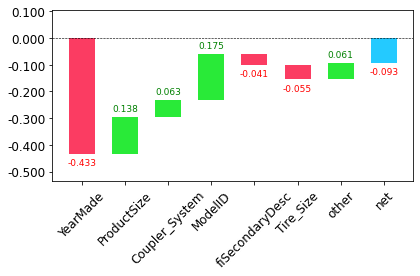

In [81]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

This kind of information is most useful in production, rather than during model development. You can use it to provide useful information to users of your data product about the underlying reasoning behind the predictions.

이러한 종류의 정보는 모델 개발 중보다는 프로덕션에서 가장 유용합니다. 이를 사용하여 데이터 제품 사용자에게 예측이면의 기본 추론에 대한 유용한 정보를 제공 할 수 있습니다.

Now that we covered some classic machine learning techniques to solve this problem, let's see how deep learning can help!

이 문제를 해결하기 위해 몇 가지 고전적인 기계 학습 기술을 다루었으므로 이제 딥 러닝이 어떻게 도움이되는지 살펴 보겠습니다!

## Extrapolation and Neural Networks(외삽 및 신경망)

A problem with random forests, like all machine learning or deep learning algorithms, is that they don't always generalize well to new data. We will see in which situations neural networks generalize better, but first, let's look at the extrapolation problem that random forests have.

모든 머신 러닝이나 딥 러닝 알고리즘과 마찬가지로 랜덤 포레스트의 문제는 항상 새로운 데이터로 잘 일반화되지 않는다는 것입니다. 어떤 상황에서 신경망이 더 잘 일반화되는지 살펴 보 겠지만 먼저 랜덤 포레스트가 갖는 외삽 문제를 살펴 보겠습니다.

### The Extrapolation Problem

In [82]:
#hide
np.random.seed(42)

Let's consider the simple task of making predictions from 40 data points showing a slightly noisy linear relationship:

약간 잡음이있는 선형 관계를 보여주는 40 개의 데이터 포인트에서 예측을 수행하는 간단한 작업을 고려해 보겠습니다.

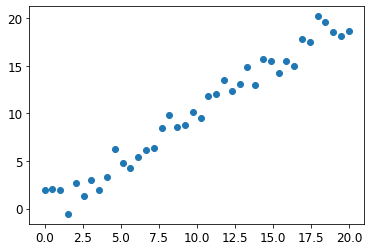

In [83]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

Although we only have a single independent variable, sklearn expects a matrix of independent variables, not a single vector. So we have to turn our vector into a matrix with one column. In other words, we have to change the *shape* from `[40]` to `[40,1]`. One way to do that is with the `unsqueeze` method, which adds a new unit axis to a tensor at the requested dimension:

독립 변수가 하나 뿐이지 만 sklearn은 단일 벡터가 아닌 독립 변수의 행렬을 기대합니다. 따라서 벡터를 하나의 열이있는 행렬로 바꿔야합니다. 즉, * 모양 *을`[40]`에서`[40,1]`로 변경해야합니다. 이를 수행하는 한 가지 방법은 요청 된 차원에서 텐서에 새 단위 축을 추가하는 ʻunsqueeze` 메서드를 사용하는 것입니다.

In [84]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

A more flexible approach is to slice an array or tensor with the special value `None`, which introduces an additional unit axis at that location:

더 유연한 접근 방식은 특수 값 'None'으로 배열 또는 텐서를 슬라이스하는 것입니다.이 경우 해당 위치에 추가 단위 축이 도입됩니다.

In [85]:
x_lin[:,None].shape

torch.Size([40, 1])

We can now create a random forest for this data. We'll use only the first 30 rows to train the model:

이제이 데이터에 대해 임의의 포리스트를 만들 수 있습니다. 모델을 학습시키기 위해 처음 30 개 행만 사용합니다.

In [86]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

Then we'll test the model on the full dataset. The blue dots are the training data, and the red dots are the predictions:

그런 다음 전체 데이터 세트에서 모델을 테스트합니다. 파란색 점은 훈련 데이터이고 빨간색 점은 예측입니다.

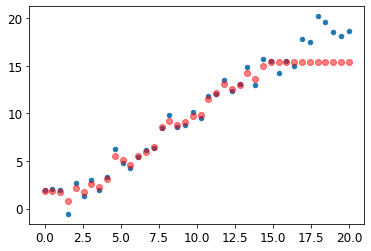

In [87]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

We have a big problem! Our predictions outside of the domain that our training data covered are all too low. Why do you suppose this is?

큰 문제가 있습니다! 우리의 훈련 데이터가 다루는 영역 외부의 예측은 모두 너무 낮습니다. 왜 그렇다고 생각합니까?

Remember, a random forest just averages the predictions of a number of trees. And a tree simply predicts the average value of the rows in a leaf. Therefore, a tree and a random forest can never predict values outside of the range of the training data. This is particularly problematic for data where there is a trend over time, such as inflation, and you wish to make predictions for a future time.. Your predictions will be systematically too low.

랜덤 포레스트는 여러 나무에 대한 예측의 평균을내는 것입니다. 그리고 나무는 단순히 잎에있는 행의 평균 값을 예측합니다. 따라서 트리와 랜덤 포레스트는 훈련 데이터 범위를 벗어난 값을 예측할 수 없습니다. 인플레이션과 같은 시간 경과에 따른 추세가 있고 미래에 대한 예측을 원하는 데이터의 경우 특히 문제가됩니다. 예측이 체계적으로 너무 낮습니다.

But the problem iextends beyond time variables. Random forests are not able to extrapolate outside of the types of data they have seen, in a more general sense. That's why we need to make sure our validation set does not contain out-of-domain data.

그러나 문제는 시간 변수를 넘어서 확장됩니다. 랜덤 포레스트는보다 일반적인 의미에서 본 데이터 유형 외부를 외삽 할 수 없습니다. 그렇기 때문에 유효성 검사 세트에 도메인 외부 데이터가 포함되어 있지 않은지 확인해야합니다.

### Finding Out-of-Domain Data

Sometimes it is hard to know whether your test set is distributed in the same way as your training data, or, if it is different, what columns reflect that difference. There's actually an easy way to figure this out, which is to use a random forest!

때로는 테스트 세트가 훈련 데이터와 같은 방식으로 분포되어 있는지 또는 다른 경우 어떤 열이 그 차이를 반영하는지 알기가 어렵습니다. 실제로 이것을 알아내는 쉬운 방법이 있습니다. 이것은 랜덤 포레스트를 사용하는 것입니다!

But in this case we don't use the random forest to predict our actual dependent variable. Instead, we try to predict whether a row is in the validation set or the training set. To see this in action, let's combine our training and validation sets together, create a dependent variable that represents which dataset each row comes from, build a random forest using that data, and get its feature importance:

그러나이 경우 실제 종속 변수를 예측하기 위해 랜덤 포레스트를 사용하지 않습니다. 대신 행이 검증 세트에 있는지 아니면 훈련 세트에 있는지 예측하려고합니다. 이를 확인하기 위해 학습 및 유효성 검사 세트를 함께 결합하고 각 행의 데이터 집합을 나타내는 종속 변수를 만들고 해당 데이터를 사용하여 임의의 포리스트를 만들고 기능 중요성을 가져 오겠습니다.

In [88]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.891571
9,SalesID,0.091174
14,MachineID,0.012950
0,YearMade,0.001520
10,Enclosure,0.000430
5,ModelID,0.000395


This shows that there are three columns that differ significantly between the training and validation sets: `saleElapsed`, `SalesID`, and `MachineID`. It's fairly obvious why this is the case for `saleElapsed`: it's the number of days between the start of the dataset and each row, so it directly encodes the date. The difference in `SalesID` suggests that identifiers for auction sales might increment over time. `MachineID` suggests something similar might be happening for individual items sold in those auctions.

이는 학습 세트와 검증 세트간에 크게 다른 세 개의 열인 'saleElapsed', 'SalesID', 'MachineID'가 있음을 보여줍니다. 이것이 'saleElapsed'의 경우 인 이유는 상당히 분명합니다. 데이터 세트의 시작과 각 행 사이의 일수이므로 날짜를 직접 인코딩합니다. 'SalesID'의 차이는 경매 판매 식별자가 시간이 지남에 따라 증가 할 수 있음을 나타냅니다. 'MachineID'는 해당 경매에서 판매되는 개별 품목에 대해 유사한 일이 발생할 수 있음을 시사합니다.

Let's get a baseline of the original random forest model's RMSE, then see what the effect is of removing each of these columns in turn:

원래 랜덤 포레스트 모델 RMSE의 기준선을 얻은 다음 이러한 각 열을 차례로 제거 할 때 어떤 효과가 있는지 살펴 보겠습니다.

In [89]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232883
SalesID 0.230347
saleElapsed 0.235529
MachineID 0.230735


It looks like we should be able to remove `SalesID` and `MachineID` without losing any accuracy. Let's check:

정확성을 잃지 않고`SalesID`와`MachineID`를 제거 할 수 있어야 할 것 같습니다. 점검 해보자:

In [90]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229498

Removing these variables has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand. We recommend that for all datasets you try building a model where your dependent variable is `is_valid`, like we did heree. It can often uncover subtle *domain shift* issues that you may otherwise miss.

이러한 변수를 제거하면 모델의 정확도가 약간 향상되었습니다. 그러나 더 중요한 것은 시간이 지남에 따라 더 탄력적이고 유지 관리 및 이해가 쉬워야한다는 것입니다. 모든 데이터 세트에 대해 여기서 한 것처럼 종속 변수가 ʻis_valid` 인 모델을 구축하는 것이 좋습니다. 그렇지 않으면 놓칠 수있는 미묘한 * 도메인 이동 * 문제를 종종 발견 할 수 있습니다.

One thing that might help in our case is to simply avoid using old data. Often, old data shows relationships that just aren't valid any more. Let's try just using the most recent few years of the data:

우리의 경우 도움이 될 수있는 한 가지는 단순히 오래된 데이터를 사용하지 않는 것입니다. 종종 오래된 데이터는 더 이상 유효하지 않은 관계를 보여줍니다. 가장 최근 몇 년간의 데이터 만 사용해 보겠습니다.

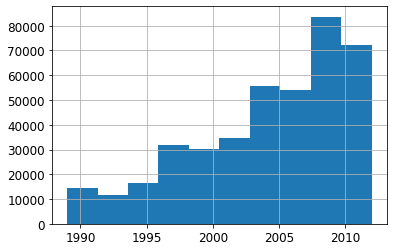

In [91]:
xs['saleYear'].hist();

Here's the result of training on this subset:

이 하위 집합에 대한 교육 결과는 다음과 같습니다.

In [92]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [93]:
m = rf(xs_filt, y_filt)
print("len of xs_filt:{}, y_filt:{}, m:{}, valid_xs_time:{}, valid_y:{}".format(len(xs_filt),len(y_filt),len(m),len(valid_xs_time),len(valid_y)))
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

len of xs_filt:230144, y_filt:230144, m:40, valid_xs_time:7988, valid_y:7988


(0.177284, 0.228008)

It's a tiny bit better, which shows that you shouldn't always just use your entire dataset; sometimes a subset can be better.
조금 더 낫습니다. 항상 전체 데이터 세트를 사용해서는 안된다는 것을 보여줍니다. 때로는 하위 집합이 더 좋을 수 있습니다.

Let's see if using a neural network helps.
신경망을 사용하는 것이 도움이되는지 살펴 보겠습니다.

### Using a Neural Network

We can use the same approach to build a neural network model. Let's first replicate the steps we took to set up the `TabularPandas` object:

동일한 접근 방식을 사용하여 신경망 모델을 구축 할 수 있습니다. 먼저`TabularPandas` 객체를 설정하기 위해 수행 한 단계를 복제 해 보겠습니다.

In [94]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

We can leverage the work we did to trim unwanted columns in the random forest by using the same set of columns for our neural network:

신경망에 동일한 열 세트를 사용하여 랜덤 포레스트에서 원하지 않는 열을 트리밍하기 위해 수행 한 작업을 활용할 수 있습니다.

In [95]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

Categorical columns are handled very differently in neural networks, compared to decision tree approaches. As we saw in <<chapter_collab>>, in a neural net a great way to handle categorical variables is by using embeddings. To create embeddings, fastai needs to determine which columns should be treated as categorical variables. It does this by comparing the number of distinct levels in the variable to the value of the `max_card` parameter. If it's lower, fastai will treat the variable as categorical. Embedding sizes larger than 10,000 should generally only be used after you've tested whether there are better ways to group the variable, so we'll use 9,000 as our `max_card`:

범주 형 열은 의사 결정 트리 접근 방식과 비교하여 신경망에서 매우 다르게 처리됩니다. << chapter_collab >>에서 보았 듯이 신경망에서 범주 형 변수를 처리하는 좋은 방법은 임베딩을 사용하는 것입니다. 임베딩을 생성하기 위해 fastai는 범주 형 변수로 처리해야하는 열을 결정해야합니다. 변수의 고유 레벨 수를`max_card` 매개 변수의 값과 비교하여이를 수행합니다. 더 낮 으면 fastai는 변수를 범주 형으로 취급합니다. 10,000보다 큰 임베딩 크기는 일반적으로 변수를 그룹화하는 더 좋은 방법이 있는지 테스트 한 후에 만 사용해야하므로`max_card`로 9,000을 사용합니다.

In [96]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In this case, however, there's one variable that we absolutely do not want to treat as categorical: the `saleElapsed` variable. A categorical variable cannot, by definition, extrapolate outside the range of values that it has seen, but we want to be able to predict auction sale prices in the future. Therefore, we need to make this a continuous variable:

그러나이 경우 절대적으로 범주 형으로 취급하고 싶지 않은 변수가 하나 있습니다. 바로 'saleElapsed'변수입니다. 범주 형 변수는 정의에 따라 자신이 본 값의 범위 밖에서 외삽 할 수 없지만 향후 경매 판매 가격을 예측할 수 있기를 원합니다. 따라서이를 연속 변수로 만들어야합니다.

In [97]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

지금까지 선택한 각 범주 형 변수의 카디널리티를 살펴 보겠습니다.

In [98]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
Hydraulics_Flow          3
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
Hydraulics              12
ProductGroup             6
fiModelDescriptor      140
Drive_System             4
Tire_Size               17
dtype: int64

The fact that there are two variables pertaining to the "model" of the equipment, both with similar very high cardinalities, suggests that they may contain similar, redundant information. Note that we would not necessarily see this when analyzing redundant features, since that relies on similar variables being sorted in the same order (that is, they need to have similarly named levels). Having a column with 5,000 levels means needing 5,000 columns in our embedding matrix, which would be nice to avoid if possible. Let's see what the impact of removing one of these model columns has on the random forest:

장비의 "모델"과 관련된 두 가지 변수가 유사하고 매우 높은 카디널리티가 있다는 사실은 유사하고 중복 된 정보를 포함 할 수 있음을 시사합니다. 중복 기능을 분석 할 때 반드시 이것을 볼 필요는 없습니다. 이는 동일한 순서로 정렬되는 유사한 변수에 의존하기 때문입니다 (즉, 비슷한 이름의 레벨이 있어야 함). 5,000 개 수준의 열이 있다는 것은 임베딩 행렬에 5,000 개의 열이 필요하다는 것을 의미하므로 가능하면 피하는 것이 좋습니다. 이러한 모델 열 중 하나를 제거하면 임의 포리스트에 미치는 영향을 살펴 보겠습니다.

In [104]:
print("0 columns len of xs_filt:{}, valid_xs_time:{}".format(len(xs_filt.columns), len(valid_xs_time.columns)))
print("1 columns of xs_filt:{}\n             valid_xs_time:{}".format(xs_filt.columns, valid_xs_time.columns))
print("2 dep_var:{}".format(dep_var))

#xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
#valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
#print("1 columns of xs_filt2:{}, valid_xs_time2:{}".format(len(xs_filt2.columns), len(valid_xs_time2.columns)))
#m2 = rf(xs_filt2, y_filt)
#print("len of xs_filt2:{}, y_filt:{}, m2:{}, valid_xs_time2:{}, valid_y:{}".format(len(xs_filt2),len(y_filt),len(m2),len(valid_xs_time2),len(valid_y)))
#m_rmse(m, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

0 columns len of xs_filt:15, valid_xs_time:15
1 columns of xs_filt:Index(['YearMade', 'ProductSize', 'Coupler_System', 'fiProductClassDesc',
       'Hydraulics_Flow', 'ModelID', 'saleElapsed', 'fiSecondaryDesc',
       'fiModelDesc', 'Enclosure', 'Hydraulics', 'ProductGroup',
       'fiModelDescriptor', 'Drive_System', 'Tire_Size'],
      dtype='object')
             valid_xs_time:Index(['YearMade', 'ProductSize', 'Coupler_System', 'fiProductClassDesc',
       'Hydraulics_Flow', 'ModelID', 'saleElapsed', 'fiSecondaryDesc',
       'fiModelDesc', 'Enclosure', 'Hydraulics', 'ProductGroup',
       'fiModelDescriptor', 'Drive_System', 'Tire_Size'],
      dtype='object')
2 dep_var:SalePrice


There's minimal impact, so we will remove it as a predictor for our neural network:

최소한의 영향이 있으므로 신경망의 예측 변수로 제거하겠습니다.

In [100]:
#cat_nn.remove('fiModelDescriptor')

We can create our `TabularPandas` object in the same way as when we created our random forest, with one very important addition: normalization. A random forest does not need any normalization—the tree building procedure cares only about the order of values in a variable, not at all about how they are scaled. But as we have seen, a neural network definitely does care about this. Therefore, we add the `Normalize` processor when we build our `TabularPandas` object:

우리는 랜덤 포레스트를 만들 때와 같은 방식으로`TabularPandas` 객체를 만들 수 있습니다. 아주 중요한 추가 사항은 정규화입니다. 랜덤 포레스트는 정규화가 필요하지 않습니다. 트리 구축 절차는 변수의 값 순서에만 신경을 쓰지 않고 스케일링 방법에 대해서는 전혀 신경 쓰지 않습니다. 그러나 우리가 보았 듯이 신경망은 확실히 이것에 관심이 있습니다. 따라서`TabularPandas` 객체를 빌드 할 때`Normalize` 프로세서를 추가합니다.

In [101]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

ValueError: Unable to coerce to Series, length must be 1: given 0

Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

테이블 형식 모델과 데이터에는 일반적으로 GPU RAM이 많이 필요하지 않으므로 더 큰 배치 크기를 사용할 수 있습니다.

In [ ]:
dls = to_nn.dataloaders(1024)

As we've discussed, it's a good idea to set `y_range` for regression models, so let's find the min and max of our dependent variable:

앞서 논의했듯이 회귀 모델에 대해 'y_range'를 설정하는 것이 좋습니다. 따라서 종속 변수의 최소값과 최대 값을 찾아 보겠습니다.

In [ ]:
y = to_nn.train.y
y.min(),y.max()

We can now create the `Learner` to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults. We set the loss function to MSE, since that's what this competition uses.

이제 '학습자'를 만들어이 테이블 형식 모델을 만들 수 있습니다. 평소와 같이 애플리케이션 별 학습자 기능을 사용하여 애플리케이션 맞춤형 기본값을 활용합니다. 이 경쟁에서 사용하는 것이기 때문에 손실 함수를 MSE로 설정했습니다.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes to 500 and 250:

기본적으로 테이블 형식 데이터의 경우 fastai는 각각 200 회 및 100 회 활성화 된 두 개의 은닉 계층이있는 신경망을 생성합니다. 이것은 작은 데이터 세트에 대해 매우 잘 작동하지만 여기에는 상당히 큰 데이터 세트가 있으므로 레이어 크기를 500 및 250으로 늘립니다.

In [ ]:
from fastai.tabular.all import *

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

In [ ]:
learn.lr_find()

There's no need to use `fine_tune`, so we'll train with `fit_one_cycle` for a few epochs and see how it looks:

`fine_tune`을 사용할 필요가 없으므로 몇 epoch 동안`fit_one_cycle`을 사용하여 훈련하고 어떻게 보이는지 확인합니다.

In [ ]:
learn.fit_one_cycle(5, 1e-2)

We can use our `r_mse` function to compare the result to the random forest result we got earlier:

`r_mse` 함수를 사용하여 결과를 이전에 얻은 랜덤 포레스트 결과와 비교할 수 있습니다.

In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

It's quite a bit better than the random forest (although it took longer to train, and it's fussier about hyperparameter tuning).
랜덤 포레스트보다 훨씬 낫습니다 (훈련 시간이 더 오래 걸리고 초 매개 변수 조정이 까다 롭지 만).

Before we move on, let's save our model in case we want to come back to it again later:
계속 진행하기 전에 나중에 다시 돌아올 경우를 대비하여 모델을 저장하겠습니다.

In [ ]:
learn.save('nn')

### Sidebar: fastai's Tabular Classes(사이드 바 : fastai의 테이블 형식 클래스)

In fastai, a tabular model is simply a model that takes columns of continuous or categorical data, and predicts a category (a classification model) or a continuous value (a regression model). Categorical independent variables are passed through an embedding, and concatenated, as we saw in the neural net we used for collaborative filtering, and then continuous variables are concatenated as well.

fastai에서 테이블 형식 모델은 단순히 연속 또는 범주 데이터 열을 가져와 범주 (분류 모델) 또는 연속 값 (회귀 모델)을 예측하는 모델입니다. 공동 필터링에 사용한 신경망에서 본 것처럼 범주 형 독립 변수는 임베딩을 통해 전달되고 연결되고 연속 변수도 연결됩니다.

The model created in `tabular_learner` is an object of class `TabularModel`. Take a look at the source for `tabular_learner` now (remember, that's `tabular_learner??` in Jupyter). You'll see that like `collab_learner`, it first calls `get_emb_sz` to calculate appropriate embedding sizes (you can override these by using the `emb_szs` parameter, which is a dictionary containing any column names you want to set sizes for manually), and it sets a few other defaults. Other than that, it just creates the `TabularModel`, and passes that to `TabularLearner` (note that `TabularLearner` is identical to `Learner`, except for a customized `predict` method).

`tabular_learner`에서 생성 된 모델은`TabularModel` 클래스의 객체입니다. 지금`tabular_learner`의 소스를 살펴보세요 (Jupyter에서`tabular_learner ??`라는 것을 기억하세요). 'collab_learner'와 마찬가지로 먼저 'get_emb_sz'를 호출하여 적절한 임베딩 크기를 계산합니다 (수동으로 크기를 설정하려는 열 이름이 포함 된 사전 인 'emb_szs'매개 변수를 사용하여이를 재정의 할 수 있음). , 몇 가지 다른 기본값을 설정합니다. 그 외에는 'TabularModel'을 생성하고이를 'TabularLearner'에 전달합니다 ( 'TabularLearner'는 사용자 정의 된 '예측'메서드를 제외하고 'Learner'와 동일합니다).

That means that really all the work is happening in `TabularModel`, so take a look at the source for that now. With the exception of the `BatchNorm1d` and `Dropout` layers (which we'll be learning about shortly), you now have the knowledge required to understand this whole class. Take a look at the discussion of `EmbeddingNN` at the end of the last chapter. Recall that it passed `n_cont=0` to `TabularModel`. We now can see why that was: because there are zero continuous variables (in fastai the `n_` prefix means "number of," and `cont` is an abbreviation for "continuous").

즉, 실제로 모든 작업이 'TabularModel'에서 일어나고 있으므로 지금 소스를 살펴보십시오. 'BatchNorm1d'및 'Dropout'레이어 (곧 배우게 될)를 제외하고 이제이 전체 클래스를 이해하는 데 필요한 지식을 얻었습니다. 마지막 챕터 마지막에있는 ʻEmbeddingNN`에 대한 논의를보십시오. `n_cont = 0`을`TabularModel`에 전달했습니다. 이제 그 이유를 알 수 있습니다. 연속 변수가 0 개이기 때문입니다 (fastai에서 'n_'접두사는 "숫자"를 의미하고 "cont"는 "연속"의 약어입니다).

### End sidebar

Another thing that can help with generalization is to use several models and average their predictions—a technique, as mentioned earlier, known as *ensembling*.

일반화에 도움이 될 수있는 또 다른 방법은 여러 모델을 사용하고 예측을 평균화하는 것입니다.이 기법은 앞서 언급했듯이 * 앙상블 링 *이라고합니다.

## Ensembling

Think back to the original reasoning behind why random forests work so well: each tree has errors, but those errors are not correlated with each other, so the average of those errors should tend towards zero once there are enough trees. Similar reasoning could be used to consider averaging the predictions of models trained using different algorithms.

랜덤 포레스트가 왜 그렇게 잘 작동하는지에 대한 원래의 추론을 다시 생각해보십시오. 각 트리에는 오류가 있지만 이러한 오류는 서로 상관되지 않으므로 트리가 충분하면 이러한 오류의 평균이 0이되는 경향이 있습니다. 유사한 추론을 사용하여 다른 알고리즘을 사용하여 훈련 된 모델의 예측을 평균화 할 수 있습니다.

In our case, we have two very different models, trained using very different algorithms: a random forest, and a neural network. It would be reasonable to expect that the kinds of errors that each one makes would be quite different. Therefore, we might expect that the average of their predictions would be better than either one's individual predictions.

우리의 경우, 랜덤 포레스트와 신경망이라는 매우 다른 알고리즘을 사용하여 훈련 된 두 개의 매우 다른 모델이 있습니다. 각 사람이 만드는 오류의 종류가 상당히 다를 것이라고 예상하는 것이 합리적입니다. 따라서 예측의 평균이 개별 예측보다 낫다고 예상 할 수 있습니다.

As we saw earlier, a random forest is itself an ensemble. But we can then include a random forest in *another* ensemble—an ensemble of the random forest and the neural network! While ensembling won't make the difference between a successful and an unsuccessful modeling process, it can certainly add a nice little boost to any models that you have built.

앞서 살펴본 것처럼 랜덤 포레스트 자체가 앙상블입니다. 그러나 우리는 랜덤 포레스트와 신경망의 앙상블 인 * 다른 * 앙상블에 랜덤 포레스트를 포함 할 수 있습니다! 앙상블 링은 성공적인 모델링 프로세스와 실패한 모델링 프로세스 사이에 차이를 만들지 않지만, 빌드 한 모든 모델에 확실히 약간의 향상을 추가 할 수 있습니다.

One minor issue we have to be aware of is that our PyTorch model and our sklearn model create data of different types: PyTorch gives us a rank-2 tensor (i.e, a column matrix), whereas NumPy gives us a rank-1 array (a vector). `squeeze` removes any unit axes from a tensor, and `to_np` converts it into a NumPy array:

우리가 알아야 할 한 가지 사소한 문제는 PyTorch 모델과 sklearn 모델이 서로 다른 유형의 데이터를 생성한다는 것입니다. PyTorch는 우리에게 랭크 2 텐서 (즉, 열 행렬)를 제공하는 반면 NumPy는 우리에게 랭크 1 배열을 제공합니다 ( 벡터). `squeeze`는 텐서에서 모든 단위 축을 제거하고`to_np`는이를 NumPy 배열로 변환합니다.

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

This gives us a better result than either model achieved on its own:

이는 두 모델이 자체적으로 달성 한 것보다 더 나은 결과를 제공합니다.

In [ ]:
r_mse(ens_preds,valid_y)

In fact, this result is better than any score shown on the Kaggle leaderboard. It's not directly comparable, however, because the Kaggle leaderboard uses a separate dataset that we do not have access to. Kaggle does not allow us to submit to this old competition to find out how we would done, but our results certainly look very encouraging!

사실이 결과는 Kaggle 리더 보드에 표시된 어떤 점수보다 낫습니다. 그러나 Kaggle 리더 보드는 액세스 권한이없는 별도의 데이터 세트를 사용하기 때문에 직접 비교할 수는 없습니다. Kaggle은 우리가 어떻게 할 것인지를 알기 위해이 오래된 대회에 참가하는 것을 허용하지 않지만, 우리의 결과는 확실히 매우 고무적입니다!

### Boosting

So far our approach to ensembling has been to use *bagging*, which involves combining many models (each trained on a different data subset) together by averaging them. As we saw, when this is applied to decision trees, this is called a *random forest*.

지금까지 앙상블에 대한 우리의 접근 방식은 * 배깅 *을 사용하는 것이 었는데, 여기에는 여러 모델 (각각 다른 데이터 하위 집합에 대해 훈련 된)을 평균화하여 결합하는 것이 포함됩니다. 우리가 보았 듯이 이것이 의사 결정 트리에 적용될 때 이것을 * 랜덤 포레스트 *라고합니다.

There is another important approach to ensembling, called *boosting*, where we add models instead of averaging them. Here is how boosting works:

앙상블에 대한 또 다른 중요한 접근 방식 인 * boosting *이 있습니다. 여기서 모델을 평균화하는 대신 추가합니다. 부스팅 작동 방식은 다음과 같습니다.

- Train a small model that underfits your dataset.
데이터 세트에 적합하지 않은 작은 모델을 학습시킵니다.

- Calculate the predictions in the training set for this model.
이 모델의 학습 세트에서 예측을 계산합니다.

- Subtract the predictions from the targets; these are called the "residuals" and represent the error for each point in the training set.
목표에서 예측을 뺍니다. 이를 "잔차"라고하며 훈련 세트의 각 지점에 대한 오류를 나타냅니다.

- Go back to step 1, but instead of using the original targets, use the residuals as the targets for the training.
1 단계로 돌아가지만 원래 목표를 사용하는 대신 잔차를 훈련의 목표로 사용합니다.

- Continue doing this until you reach some stopping criterion, such as a maximum number of trees, or you observe your validation set error getting worse.
최대 트리 수와 같은 일부 중지 기준에 도달하거나 검증 세트 오류가 악화되는 것을 관찰 할 때까지이 작업을 계속하십시오.

Using this approach, each new tree will be attempting to fit the error of all of the previous trees combined. Because we are continually creating new residuals, by subtracting the predictions of each new tree from the residuals from the previous tree, the residuals will get smaller and smaller.

이 접근 방식을 사용하면 각각의 새 트리는 결합 된 모든 이전 트리의 오류를 맞추려고 시도합니다. 우리는 계속해서 새로운 잔차를 생성하기 때문에 이전 트리의 잔차에서 각각의 새로운 나무에 대한 예측을 빼면 잔차가 점점 더 작아집니다.

To make predictions with an ensemble of boosted trees, we calculate the predictions from each tree, and then add them all together. There are many models following this basic approach, and many names for the same models. *Gradient boosting machines* (GBMs) and *gradient boosted decision trees* (GBDTs) are the terms you're most likely to come across, or you may see the names of specific libraries implementing these; at the time of writing, *XGBoost* is the most popular.

부스트 트리의 앙상블을 사용하여 예측을 수행하기 위해 각 트리에서 예측을 계산 한 다음 모두 합산합니다. 이 기본 접근 방식을 따르는 많은 모델이 있으며 동일한 모델에 대한 많은 이름이 있습니다. * Gradient Boosting Machine * (GBM) 및 * Gradient Boosted Decision Tree * (GBDT)는 가장 많이 접하게 될 용어이거나이를 구현하는 특정 라이브러리의 이름을 볼 수 있습니다. 작성 당시에는 * XGBoost *가 가장 인기가 있습니다.

Note that, unlike with random forests, with this approach there is nothing to stop us from overfitting. Using more trees in a random forest does not lead to overfitting, because each tree is independent of the others. But in a boosted ensemble, the more trees you have, the better the training error becomes, and eventually you will see overfitting on the validation set.

랜덤 포레스트와 달리이 접근 방식을 사용하면 과적 합을 막을 수 없습니다. 임의의 포리스트에서 더 많은 나무를 사용하면 각 나무가 다른 나무와 독립적이기 때문에 과적 합으로 이어지지 않습니다. 그러나 부스트 된 앙상블에서는 트리가 많을수록 훈련 오류가 더 좋아지며 결국 검증 세트에서 과적 합을 보게됩니다.

We are not going to go into detail on how to train a gradient boosted tree ensemble here, because the field is moving rapidly, and any guidance we give will almost certainly be outdated by the time you read this. As we write this, sklearn has just added a `HistGradientBoostingRegressor` class that provides excellent performance. There are many hyperparameters to tweak for this class, and for all gradient boosted tree methods we have seen. Unlike random forests, gradient boosted trees are extremely sensitive to the choices of these hyperparameters; in practice, most people use a loop that tries a range of different hyperparameters to find the ones that work best.

필드가 빠르게 이동하고 있기 때문에 여기서는 그라디언트 부스트 트리 앙상블을 훈련하는 방법에 대해 자세히 설명하지 않을 것입니다. 우리가 제공하는 지침은이 글을 읽을 때쯤에는 거의 확실히 구식 일 것입니다. 이 글을 작성할 때 sklearn은 뛰어난 성능을 제공하는`HistGradientBoostingRegressor` 클래스를 방금 추가했습니다. 이 클래스와 우리가 본 모든 그라디언트 부스트 트리 메서드에 대해 조정할 수있는 하이퍼 파라미터가 많이 있습니다. 랜덤 포레스트와 달리 그래디언트 부스트 트리는 이러한 하이퍼 파라미터의 선택에 매우 민감합니다. 실제로 대부분의 사람들은 다양한 하이퍼 파라미터를 시도하는 루프를 사용하여 가장 잘 작동하는 하이퍼 파라미터를 찾습니다.

One more technique that has gotten great results is to use embeddings learned by a neural net in a machine learning model.

훌륭한 결과를 얻은 또 하나의 기술은 기계 학습 모델에서 신경망이 학습 한 임베딩을 사용하는 것입니다.

### Combining Embeddings with Other Methods(임베딩을 다른 방법과 결합)

The abstract of the entity embedding paper we mentioned at the start of this chapter states: "the embeddings obtained from the trained neural network boost the performance of all tested machine learning methods considerably when used as the input features instead". It includes the very interesting table in <<embedding_mixed>>.

이 장의 시작 부분에서 언급 한 엔터티 임베딩 논문의 요약에는 "훈련 된 신경망에서 얻은 임베딩이 대신 입력 특성으로 사용될 때 테스트 된 모든 기계 학습 방법의 성능을 상당히 향상시킵니다"라고 말합니다. << embedding_mixed >>에 매우 흥미로운 테이블이 포함되어 있습니다.

<img alt="Embeddings combined with other methods" width="500" id="embedding_mixed" caption="Effects of using neural network embeddings as input to other machine learning methods (courtesy of Cheng Guo and Felix Berkhahn)" src="images/att_00054.png">

This is showing the mean average percent error (MAPE) compared among four different modeling techniques, three of which we have already seen, along with *k*-nearest neighbors (KNN), which is a very simple baseline method. The first numeric column contains the results of using the methods on the data provided in the competition; the second column shows what happens if you first train a neural network with categorical embeddings, and then use those categorical embeddings instead of the raw categorical columns in the model. As you see, in every case, the models are dramatically improved by using the embeddings instead of the raw categories.

이것은 매우 간단한 기준 방법 인 * k *-최근 접 이웃 (KNN)과 함께 이미 살펴본 4 가지 모델링 기술 간의 평균 평균 백분율 오류 (MAPE)를 보여줍니다. 첫 번째 숫자 열에는 대회에서 제공된 데이터에 대한 방법을 사용한 결과가 포함됩니다. 두 번째 열은 먼저 범주 형 임베딩으로 신경망을 훈련 한 다음 모델의 원시 범주 형 열 대신 해당 범주 형 임베딩을 사용하는 경우 발생하는 상황을 보여줍니다. 보시다시피 모든 경우에 원시 범주 대신 임베딩을 사용하여 모델이 크게 향상됩니다.

This is a really important result, because it shows that you can get much of the performance improvement of a neural network without actually having to use a neural network at inference time. You could just use an embedding, which is literally just an array lookup, along with a small decision tree ensemble.

이것은 추론 시간에 실제로 신경망을 사용하지 않고도 신경망의 성능 향상을 상당 부분 얻을 수 있다는 것을 보여주기 때문에 정말 중요한 결과입니다. 작은 의사 결정 트리 앙상블과 함께 문자 그대로 배열 조회 인 임베딩을 사용할 수 있습니다.

These embeddings need not even be necessarily learned separately for each model or task in an organization. Instead, once a set of embeddings are learned for some column for some task, they could be stored in a central place, and reused across multiple models. In fact, we know from private communication with other practitioners at large companies that this is already happening in many places.

이러한 임베딩은 조직의 각 모델 또는 작업에 대해 반드시 별도로 학습 할 필요는 없습니다. 대신 일부 작업의 일부 열에 대해 임베딩 세트가 학습되면 중앙 위치에 저장하고 여러 모델에서 재사용 할 수 있습니다. 사실, 우리는 대기업의 다른 실무자들과의 비공개 커뮤니케이션을 통해 이미 많은 곳에서 이런 일이 일어나고 있음을 알고 있습니다.

## Conclusion: Our Advice for Tabular Modeling(결론 : 테이블 형식 모델링에 대한 조언)

We have dicussed two approaches to tabular modeling: decision tree ensembles and neural networks. We've also mentioned two different decision tree ensembles: random forests, and gradient boosting machines. Each is very effective, but each also has compromises:
테이블 형식 모델링에 대한 두 가지 접근 방식 인 의사 결정 트리 앙상블과 신경망을 논의했습니다. 또한 랜덤 포레스트와 그래디언트 부스팅 머신이라는 두 가지 의사 결정 트리 앙상블을 언급했습니다. 각각은 매우 효과적이지만 각각 타협도 있습니다.

- *Random forests* are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. But they can be a little less accurate, especially if extrapolation is required, such as predicting future time periods.

* 랜덤 포레스트 *는 하이퍼 파라미터 선택에 매우 탄력적이고 전처리가 거의 필요하지 않기 때문에 훈련하기 가장 쉽습니다. 훈련 속도가 매우 빠르며 나무가 충분하면 과적 합해서는 안됩니다. 그러나 특히 미래 기간 예측과 같은 외삽이 필요한 경우에는 정확도가 약간 떨어질 수 있습니다.

- *Gradient boosting machines* in theory are just as fast to train as random forests, but in practice you will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.

이론상 * 그라디언트 부스팅 머신 *은 랜덤 포레스트만큼 빠르게 훈련 할 수 있지만 실제로는 다양한 하이퍼 파라미터를 시도해야합니다. 과적 합할 수 있지만 종종 임의의 숲보다 약간 더 정확합니다.

- *Neural networks* take the longest time to train, and require extra preprocessing, such as normalization; this normalization needs to be used at inference time as well. They can provide great results and extrapolate well, but only if you are careful with your hyperparameters and take care to avoid overfitting.

* 신경망 *은 훈련하는 데 가장 오랜 시간이 걸리며 정규화와 같은 추가 전처리가 필요합니다. 이 정규화는 추론 시간에도 사용해야합니다. 훌륭한 결과를 제공하고 잘 외삽 할 수 있지만 하이퍼 파라미터에주의하고 과적 합을 방지하기 위해주의를 기울여야합니다.

We suggest starting your analysis with a random forest. This will give you a strong baseline, and you can be confident that it's a reasonable starting point. You can then use that model for feature selection and partial dependence analysis, to get a better understanding of your data.

무작위 포리스트로 분석을 시작하는 것이 좋습니다. 이것은 당신에게 강력한 기준을 제공 할 것이며 합리적인 출발점이라고 확신 할 수 있습니다. 그런 다음 해당 모델을 기능 선택 및 부분 종속성 분석에 사용하여 데이터를 더 잘 이해할 수 있습니다.

From that foundation, you can try neural nets and GBMs, and if they give you significantly better results on your validation set in a reasonable amount of time, you can use them. If decision tree ensembles are working well for you, try adding the embeddings for the categorical variables to the data, and see if that helps your decision trees learn better.

그 기반에서 신경망과 GBM을 사용해 볼 수 있으며, 합리적인 시간 내에 유효성 검사 세트에 대해 훨씬 더 나은 결과를 제공하는 경우 사용할 수 있습니다. 의사 결정 트리 앙상블이 잘 작동하는 경우 범주 형 변수에 대한 임베딩을 데이터에 추가하고 의사 결정 트리가 더 잘 학습하는 데 도움이되는지 확인하십시오.

## Questionnaire

1. What is a continuous variable?
1. What is a categorical variable?
1. Provide two of the words that are used for the possible values of a categorical variable.
1. What is a "dense layer"?
1. How do entity embeddings reduce memory usage and speed up neural networks?
1. What kinds of datasets are entity embeddings especially useful for?
1. What are the two main families of machine learning algorithms?
1. Why do some categorical columns need a special ordering in their classes? How do you do this in Pandas?
1. Summarize what a decision tree algorithm does.
1. Why is a date different from a regular categorical or continuous variable, and how can you preprocess it to allow it to be used in a model?
1. Should you pick a random validation set in the bulldozer competition? If no, what kind of validation set should you pick?
1. What is pickle and what is it useful for?
1. How are `mse`, `samples`, and `values` calculated in the decision tree drawn in this chapter?
1. How do we deal with outliers, before building a decision tree?
1. How do we handle categorical variables in a decision tree?
1. What is bagging?
1. What is the difference between `max_samples` and `max_features` when creating a random forest?
1. If you increase `n_estimators` to a very high value, can that lead to overfitting? Why or why not?
1. In the section "Creating a Random Forest", just after <<max_features>>, why did `preds.mean(0)` give the same result as our random forest?
1. What is "out-of-bag-error"?
1. Make a list of reasons why a model's validation set error might be worse than the OOB error. How could you test your hypotheses?
1. Explain why random forests are well suited to answering each of the following question:
   - How confident are we in our predictions using a particular row of data?
   - For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
   - Which columns are the strongest predictors?
   - How do predictions vary as we vary these columns?
1. What's the purpose of removing unimportant variables?
1. What's a good type of plot for showing tree interpreter results?
1. What is the "extrapolation problem"?
1. How can you tell if your test or validation set is distributed in a different way than your training set?
1. Why do we make `saleElapsed` a continuous variable, even although it has less than 9,000 distinct values?
1. What is "boosting"?
1. How could we use embeddings with a random forest? Would we expect this to help?
1. Why might we not always use a neural net for tabular modeling?

### Further Research

1. Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard.
1. Implement the decision tree algorithm in this chapter from scratch yourself, and try it on the datase you used in the first exercise.
1. Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.
1. Explain what each line of the source of `TabularModel` does (with the exception of the `BatchNorm1d` and `Dropout` layers).